### Contents:

- Covid-19 global data analysis.
- Comparing trajectories of deaths, confirmed and active cases for different countries.
- Time Series forecasting: Using ARIMA model to predict deaths in US and India for next 15 days.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import csv
import itertools
from collections import defaultdict
import datetime as dt
import re
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statistics

%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 50)
plt.rcParams["figure.figsize"] = [10, 10]
sns.set_style('darkgrid')

In [3]:
base_dir = '../data/Global/csse_covid_19_daily_reports/'

In [4]:
abs_path = os.path.abspath(base_dir)

In [5]:
files = os.listdir(abs_path)
csv_files = filter(lambda file: '.csv' in file, files)
csv_abs_path = [os.path.join(abs_path, csv_file) for csv_file in csv_files]

In [6]:
csv_abs_path = sorted(csv_abs_path)

In [7]:
covid_list_6_columns = []
covid_list_8_columns = []
covid_list_12_columns = []
covid_list_14_columns = []
d = defaultdict()
for file in csv_abs_path:
    with open(file, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader) 
        l = [i for i in reader]
        size = len(l[0])
        d[size] = size + 1
    if size == 6:
        covid_list_6_columns.extend(l)
    elif size == 8:
        covid_list_8_columns.extend(l)
    elif size == 12:
        covid_list_12_columns.extend(l)
    elif size == 14:
        covid_list_14_columns.extend(l)

### Columns:

- df6: Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
- df8: Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
- df12: 'FIPS','Admin2','Province_State','Country_Region','Last_Update','Lat','Long_','Confirmed','Deaths','Recovered','Active','Combined_Key'
- df14: 'FIPS','Admin2','Province_State','Country_Region','Last_Update','Lat','Long_','Confirmed','Deaths','Recovered','Active','Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio'


### Create DataFrame

In [8]:
df6 = pd.DataFrame(covid_list_6_columns, columns=['Province/State','Country/Region','Last Update','Confirmed','Deaths','Recovered'])
df8 = pd.DataFrame(covid_list_8_columns, columns=['Province/State','Country/Region','Last Update','Confirmed','Deaths','Recovered','Latitude','Longitude'])
df12 = pd.DataFrame(covid_list_12_columns, columns=['FIPS','Admin2','Province_State','Country_Region','Last_Update','Lat','Long_','Confirmed','Deaths','Recovered','Active','Combined_Key'])
df14 = pd.DataFrame(covid_list_14_columns, columns=['FIPS','Admin2','Province_State','Country_Region','Last_Update','Lat','Long_','Confirmed','Deaths','Recovered','Active','Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio'])

In [9]:
df6.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,Anhui,Mainland China,1/22/2020 17:00,1,,
1,Beijing,Mainland China,1/22/2020 17:00,14,,
2,Chongqing,Mainland China,1/22/2020 17:00,6,,
3,Fujian,Mainland China,1/22/2020 17:00,1,,
4,Gansu,Mainland China,1/22/2020 17:00,,,


In [10]:
df8.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,Mainland China,2020-03-01T10:13:19,66907,2761,31536,30.9756,112.2707
1,,South Korea,2020-03-01T23:43:03,3736,17,30,36.0000,128.0000
2,,Italy,2020-03-01T23:23:02,1694,34,83,43.0000,12.0000
3,Guangdong,Mainland China,2020-03-01T14:13:18,1349,7,1016,23.3417,113.4244
4,Henan,Mainland China,2020-03-01T14:13:18,1272,22,1198,33.8820,113.6140


In [11]:
df12.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,36061,New York City,New York,US,3/22/20 23:45,40.7672726,-73.97152637,9654,63,0,0,"New York City, New York, US"
1,36059,Nassau,New York,US,3/22/20 23:45,40.74066522,-73.58941873,1900,4,0,0,"Nassau, New York, US"
2,36119,Westchester,New York,US,3/22/20 23:45,41.16278376,-73.75741653,1873,0,0,0,"Westchester, New York, US"
3,36103,Suffolk,New York,US,3/22/20 23:45,40.88320119,-72.8012172,1034,9,0,0,"Suffolk, New York, US"
4,36087,Rockland,New York,US,3/22/20 23:45,41.15027894,-74.02560498,455,1,0,0,"Rockland, New York, US"


In [12]:
df14.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,45001,Abbeville,South Carolina,US,2020-05-30 02:32:48,34.22333378,-82.46170658,39,0,0,39,"Abbeville, South Carolina, US",159.0084396787214,0.0
1,22001,Acadia,Louisiana,US,2020-05-30 02:32:48,30.2950649,-92.41419698,401,23,0,378,"Acadia, Louisiana, US",646.305101136272,5.7356608478802995
2,51001,Accomack,Virginia,US,2020-05-30 02:32:48,37.76707161,-75.63234615,827,12,0,815,"Accomack, Virginia, US",2559.1038494863224,1.4510278113663846
3,16001,Ada,Idaho,US,2020-05-30 02:32:48,43.4526575,-116.24155159999998,803,22,0,781,"Ada, Idaho, US",166.7403812810562,2.73972602739726
4,19001,Adair,Iowa,US,2020-05-30 02:32:48,41.33075609,-94.47105874,9,0,0,9,"Adair, Iowa, US",125.83892617449665,0.0


In [13]:
df6['Last Update'].dtype

dtype('O')

In [14]:
len(df6)

2818

In [15]:
len(df12)

214844

In [16]:
len(df12) + len(df8) + len(df6)

222461

### Merge 3 DataFrames

In [17]:
df1 = pd.concat([df6, df8, df12, df14], axis=0, sort=False)

In [18]:
df1.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,Anhui,Mainland China,1/22/2020 17:00,1,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Beijing,Mainland China,1/22/2020 17:00,14,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Chongqing,Mainland China,1/22/2020 17:00,6,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fujian,Mainland China,1/22/2020 17:00,1,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gansu,Mainland China,1/22/2020 17:00,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning

In [19]:
df1['Country/Region'] = df1['Country/Region'].fillna('')
df1['Country_Region'] = df1['Country_Region'].fillna('')
df1['Country_Region'] = df1['Country_Region'] + df1['Country/Region']

In [20]:
df1 = df1.drop(columns='Country/Region')

In [21]:
df1['Last Update'] = df1['Last Update'].fillna('')
df1['Last_Update'] = df1['Last_Update'].fillna('')
df1['Last_Update'] = df1['Last_Update'] + df1['Last Update']
df1 = df1.drop(columns=['Last Update'])

In [22]:
df1['Province/State'] = df1['Province/State'].fillna('')
df1['Province_State'] = df1['Province_State'].fillna('')
df1['Province_State'] = df1['Province_State'] + df1['Province/State']
df1 = df1.drop(columns=['Province/State'])

#### Uniform Datetime format

- DataFrame has 4-5 different datetime formats.
- When pd.to_datetime is used, majority of the dates become NAT, because it is not able to infer them.
- The problem is solved using dateutil package.

In [23]:
import dateutil.parser
date = dateutil.parser.parse("1/23/20 17:00").strftime("%m/%d/%Y, %H:%M:%S")
date

'01/23/2020, 17:00:00'

In [24]:
df1['Last_Update'] = df1['Last_Update'].apply(lambda x: dateutil.parser.parse(x).strftime("%Y-%m-%d %H:%M:%S"))

In [25]:
df1['Last_Update'] = pd.to_datetime(df1['Last_Update'], infer_datetime_format=True, errors='coerce')

In [26]:
df1.isna().sum()

Confirmed                   0
Deaths                      0
Recovered                   0
Latitude               408714
Longitude              408714
FIPS                     7617
Admin2                   7617
Province_State              0
Country_Region              0
Last_Update                 0
Lat                      7617
Long_                    7617
Active                   7617
Combined_Key             7617
Incidence_Rate         222461
Case-Fatality_Ratio    222461
dtype: int64

#### Only 4799 rows have latitude and longitude values out of 201896 rows, that is 2%, thus removing those columns. 

In [27]:
df1 = df1.drop(columns=['Latitude', 'Longitude'])

In [28]:
df1.isna().sum()

Confirmed                   0
Deaths                      0
Recovered                   0
FIPS                     7617
Admin2                   7617
Province_State              0
Country_Region              0
Last_Update                 0
Lat                      7617
Long_                    7617
Active                   7617
Combined_Key             7617
Incidence_Rate         222461
Case-Fatality_Ratio    222461
dtype: int64

In [29]:
df1['date'] = pd.to_datetime(df1['Last_Update']).dt.date

In [30]:
df1.loc[df1['Country_Region'].isin(['Mainland China', 'China']), 'Country_Region'] = 'China'

In [31]:
df1.Deaths.unique()

array(['', '17', '1', ..., '1773', '4948', '5475'], dtype=object)

### Check and update datatypes if not correct

In [32]:
df1.loc[df1['Deaths'] == '', 'Deaths'] = 0

In [33]:
df1.loc[df1['Recovered'] == '', 'Recovered'] = 0

In [34]:
df1.loc[df1['Confirmed'] == '', 'Confirmed'] = 0

In [35]:
df1['Active'] = df1['Active'].fillna(0)

In [36]:
df1.dtypes

Confirmed                      object
Deaths                         object
Recovered                      object
FIPS                           object
Admin2                         object
Province_State                 object
Country_Region                 object
Last_Update            datetime64[ns]
Lat                            object
Long_                          object
Active                         object
Combined_Key                   object
Incidence_Rate                 object
Case-Fatality_Ratio            object
date                           object
dtype: object

In [37]:
df1.isna().sum()

Confirmed                   0
Deaths                      0
Recovered                   0
FIPS                     7617
Admin2                   7617
Province_State              0
Country_Region              0
Last_Update                 0
Lat                      7617
Long_                    7617
Active                      0
Combined_Key             7617
Incidence_Rate         222461
Case-Fatality_Ratio    222461
date                        0
dtype: int64

In [38]:
df1.loc[df1.Active == '', 'Active'] = 0

In [39]:
df1[['Confirmed', 'Deaths', 'Recovered', 'Active']] = df1[['Confirmed', 'Deaths', 'Recovered', 'Active']].astype(np.int)

In [40]:
df1['Active_Cases'] = df1['Confirmed'] - df1['Deaths'] - df1['Recovered']

#### New Feature

In [41]:
df1[(~df1['Active'].isna()) & ( df1['Active'] != 0 )]

,Confirmed,Deaths,Recovered,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio,date,Active_Cases
3189,669,6,4,,,New South Wales,Australia,2020-03-22 23:48:00,-33.8688,151.2093,659,"New South Wales, Australia",NaN,NaN,2020-03-22,659
3190,296,0,70,,,Victoria,Australia,2020-03-22 23:48:00,-37.8136,144.9631,226,"Victoria, Australia",NaN,NaN,2020-03-22,226
3191,259,0,8,,,Queensland,Australia,2020-03-22 23:48:00,-27.4698,153.0251,251,"Queensland, Australia",NaN,NaN,2020-03-22,251
3192,120,1,1,,,Western Australia,Australia,2020-03-22 23:48:00,-31.9505,115.8605,118,"Western Australia, Australia",NaN,NaN,2020-03-22,118
3193,100,0,6,,,South Australia,Australia,2020-03-22 23:48:00,-34.9285,138.6007,94,"South Australia, Australia",NaN,NaN,2020-03-22,94
3194,22,0,3,,,Tasmania,Australia,2020-03-22 23:48:00,-42.8821,147.3272,19,"Tasmania, Australia",NaN,NaN,2020-03-22,19
3195,19,0,0,,,Australian Capital Territory,Australia,2020-03-22 23:48:00,-35.4735,149.0124,19,"Australian Capital Territory, Australia",NaN,NaN,2020-03-22,19
3196,5,0,0,,,Northern Territory,Australia,2020-03-22 23:48:00,-12.4634,130.8456,5,"Northern Territory, Australia",NaN,NaN,2020-03-22,5
3199,20,0,10,,,Macau,China,2020-03-22 14:23:00,22.1667,113.55,10,"Macau, China",NaN,NaN,2020-03-22,10
3200,136,2,114,,,Gansu,China,2020-03-22 14:23:00,37.8099,101.0583,20,"Gansu, China",NaN,NaN,2020-03-22,20


In [42]:
df1.date = pd.to_datetime(df1['date'])

In [43]:
df1.dtypes

Confirmed                       int64
Deaths                          int64
Recovered                       int64
FIPS                           object
Admin2                         object
Province_State                 object
Country_Region                 object
Last_Update            datetime64[ns]
Lat                            object
Long_                          object
Active                          int64
Combined_Key                   object
Incidence_Rate                 object
Case-Fatality_Ratio            object
date                   datetime64[ns]
Active_Cases                    int64
dtype: object

In [44]:
df_china = df1.loc[(df1['Country_Region'] == 'China') & (df1['Confirmed'] != 0)]

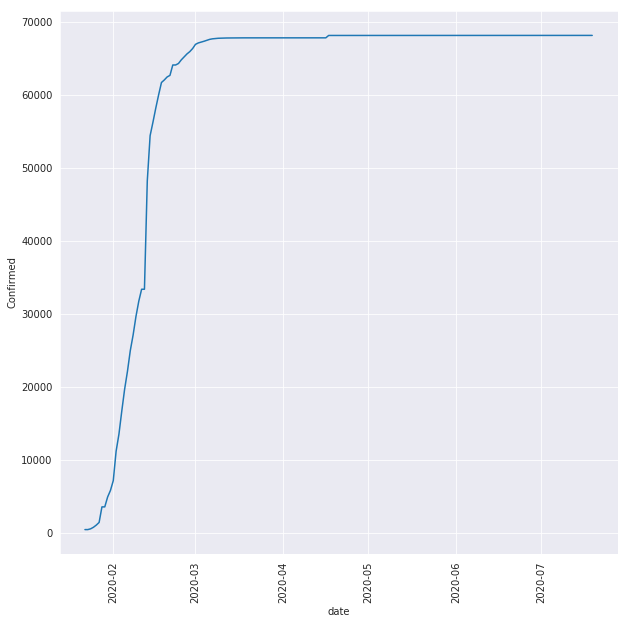

In [45]:
sns.lineplot(x='date', y='Confirmed', data=df_china.loc[df_china.Province_State == 'Hubei'])
plt.xticks(rotation=90)
plt.show()

#### Notice the sharp increase in number of deaths, when the curve had already flattened.

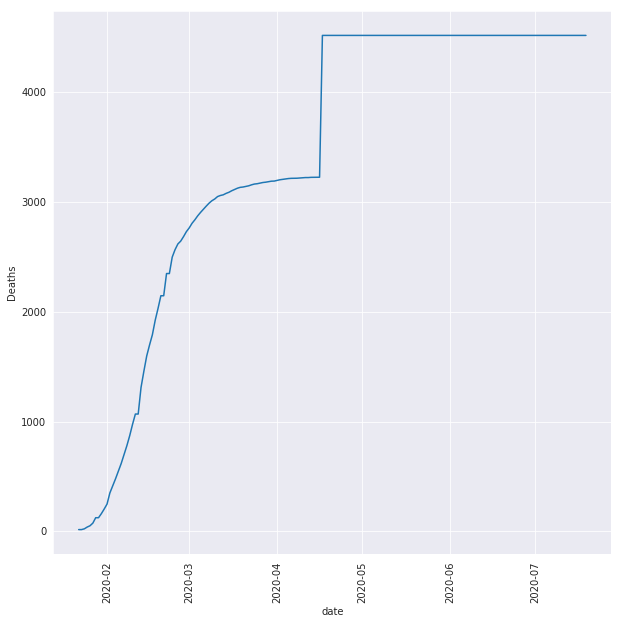

In [46]:
sns.lineplot(x='date', y='Deaths', data=df_china.loc[df_china.Province_State == 'Hubei'])
plt.xticks(rotation=90)
plt.show()

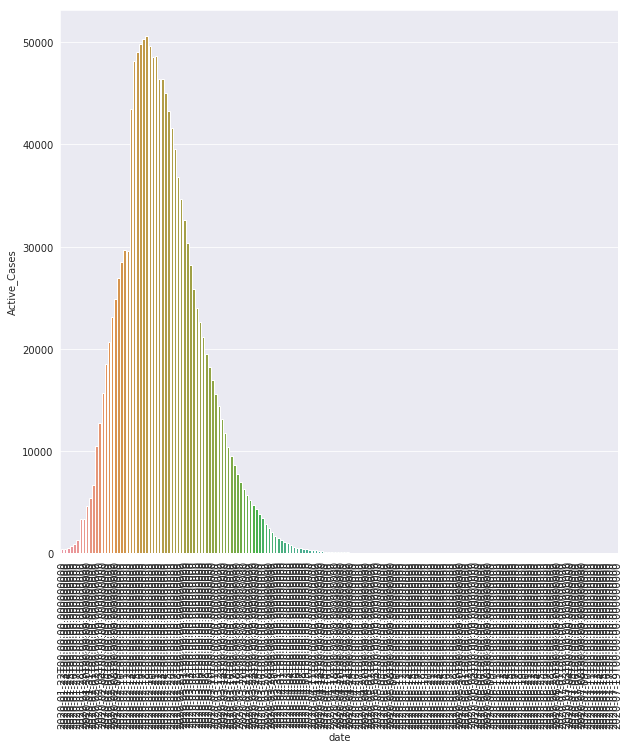

In [47]:
sns.barplot(x='date', y='Active_Cases', data=df_china.loc[df_china.Province_State == 'Hubei'])
plt.xticks(rotation=90)
plt.show()

In [48]:
df_china.groupby(['Province_State'])['Deaths'].max().sort_values(ascending=False)

Province_State
Hubei             4512
Henan               22
Heilongjiang        13
Hong Kong           10
Beijing              9
Guangdong            8
Shanghai             7
Shandong             7
Hainan               6
Anhui                6
Chongqing            6
Hebei                6
Hunan                4
Shaanxi              3
Sichuan              3
Tianjin              3
Xinjiang             3
Gansu                2
Liaoning             2
Jilin                2
Guangxi              2
Yunnan               2
Guizhou              2
Fujian               1
Zhejiang             1
Inner Mongolia       1
Jiangxi              1
Macau                0
Ningxia              0
Qinghai              0
Shanxi               0
Tibet                0
Jiangsu              0
Name: Deaths, dtype: int64

In [49]:
yesterday = (dt.datetime.now().date() - dt.timedelta(days=1)).strftime('%Y-%m-%d')

In [50]:
yesterday

'2020-07-18'

In [51]:
df1[df1.date == yesterday].groupby(['Country_Region']).sum().sort_values(by='Deaths', ascending=False).head(10)

,Confirmed,Deaths,Recovered,Active,Active_Cases
Country_Region,,,,,
US,3647713,139266,1107204,2441843,2401243
Brazil,2046328,77851,1428520,539957,539957
United Kingdom,294803,45318,1403,248082,248082
Mexico,331298,38310,264202,28786,28786
Italy,243967,35028,196483,12456,12456
France,211943,30155,79371,102417,102417
Spain,260255,28420,150376,81459,81459
India,1039084,26273,653751,359060,359060
Iran,269440,13791,232873,22776,22776


In [52]:
df2 = df1.loc[df1.date == yesterday].groupby(['Province_State']).max()#.sort_values(by=['Deaths', 'Confirmed', 'Active', 'Recovered'], ascending=['False', 'False', 'False', 'False'])

### Analysis

- Top 10 countries with maximum fatalities
- Top 10 Provincies in US with maximum fatalities
- Countries with highest fatalities to recovery ratio
- Countries with maximum recovery rate
- Country with most active cases
- Country with largest single day spike in: 
    - Deaths
    - Confirmed
    - Recovered

#### Top Provinces / States with Maximum Fatalities

In [53]:
provincies_with_maximum_fatalities = df2.sort_values(by='Deaths', ascending=False)
top_10_provinces_with_maximum_fatalities = provincies_with_maximum_fatalities.head(10)

In [54]:
top_10_provinces_with_maximum_fatalities

,Confirmed,Deaths,Recovered,FIPS,Admin2,Country_Region,Last_Update,Lat,Long_,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio,date,Active_Cases
Province_State,,,,,,,,,,,,,,,
England,252117,40640,0,,,United Kingdom,2020-07-18 04:34:45,52.3555,-1.1743,211477,"England, United Kingdom",450.39230258033615,16.119500073378628,2020-07-18,211477
,337594,30049,232873,,,Zimbabwe,2020-07-18 23:34:47,9.9456,95.956,154607,Zimbabwe,97.91676617557538,8.527131782945736,2020-07-18,154607
New York,220734,23377,0,90036,Yates,US,2020-07-18 04:34:45,44.74530905,-79.36691763,197357,"Yates, New York, US",93.7778829870532,9.022556390977444,2020-07-18,197357
Sao Paulo,407415,19377,255768,,,Brazil,2020-07-18 04:34:45,-23.5505,-46.6333,132270,"Sao Paulo, Brazil",887.2461622626372,4.756084091160119,2020-07-18,132270
Lombardia,95371,16778,71172,,,Italy,2020-07-18 04:34:45,45.46679409,9.190347404,7421,"Lombardia, Italy",947.967779969612,17.592349875748393,2020-07-18,7421
Rio de Janeiro,135230,11919,115201,,,Brazil,2020-07-18 04:34:45,-22.9068,-43.1729,8110,"Rio de Janeiro, Brazil",783.2635184489169,8.813872661391702,2020-07-18,8110
Maharashtra,292589,11452,160357,,,India,2020-07-18 04:34:45,19.449759,76.108221,120780,"Maharashtra, India",237.59864074175854,3.914022741798222,2020-07-18,120780
Madrid,73026,8446,40736,,,Spain,2020-07-18 04:34:45,40.4168,-3.7038,23844,"Madrid, Spain",1099.5160990892473,11.565743707720538,2020-07-18,23844
Ciudad de Mexico,61351,8101,49295,,,Mexico,2020-07-18 04:34:45,19.4326,-99.1332,3955,"Ciudad de Mexico, Mexico",680.2684882263355,13.20434874737168,2020-07-18,3955


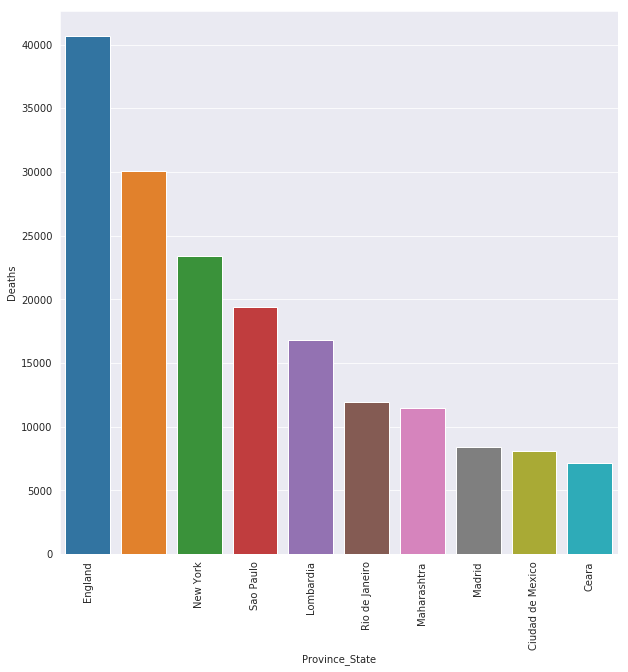

In [55]:
sns.barplot(data = top_10_provinces_with_maximum_fatalities, 
            x=top_10_provinces_with_maximum_fatalities.index, 
            y='Deaths')
plt.xticks(rotation=90)
plt.show()

#### Top 10 countries with maximum fatalities

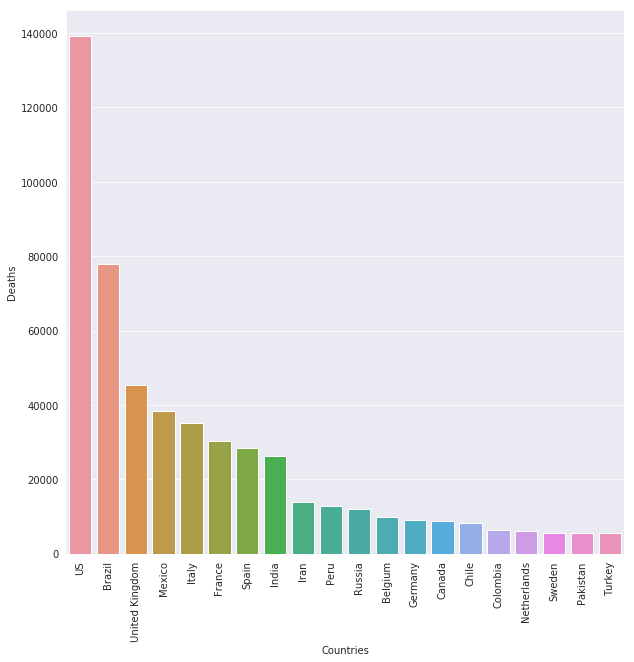

In [56]:
top_20_countries_most_deaths = df1[df1.date == yesterday].groupby(['Country_Region']).sum().sort_values(by='Deaths', ascending=False).head(20)
sns.barplot(data = top_20_countries_most_deaths, x=top_20_countries_most_deaths.index, y='Deaths')
plt.xticks(rotation=90)
plt.xlabel('Countries')
plt.show()

#### Top 10 Countries with most active cases

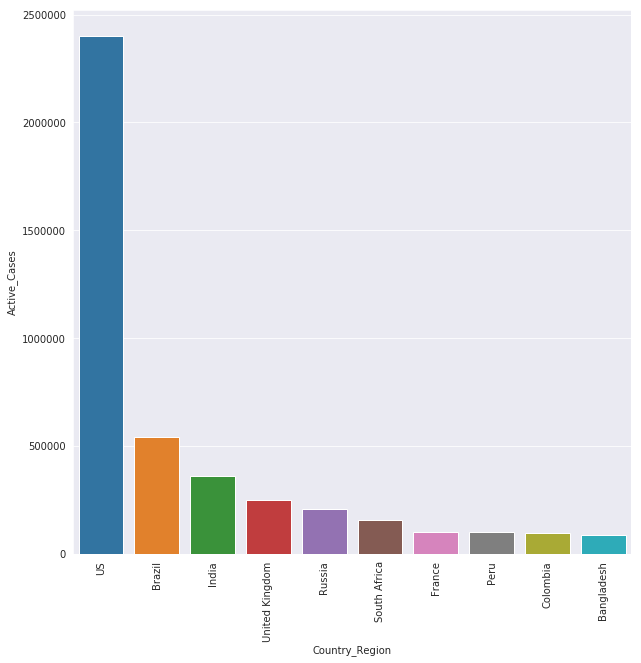

In [57]:
df3 = df1.loc[df1.date == yesterday].groupby(['Country_Region'])['Active_Cases'].sum()#.iloc[1:, :].head(10)
top_20_countries_most_active_cases = df3.sort_values(ascending=False)[:10]
sns.barplot(x=top_20_countries_most_active_cases.index, y=top_20_countries_most_active_cases)
plt.xticks(rotation=90)
plt.show()

#### Countries with most recoveries

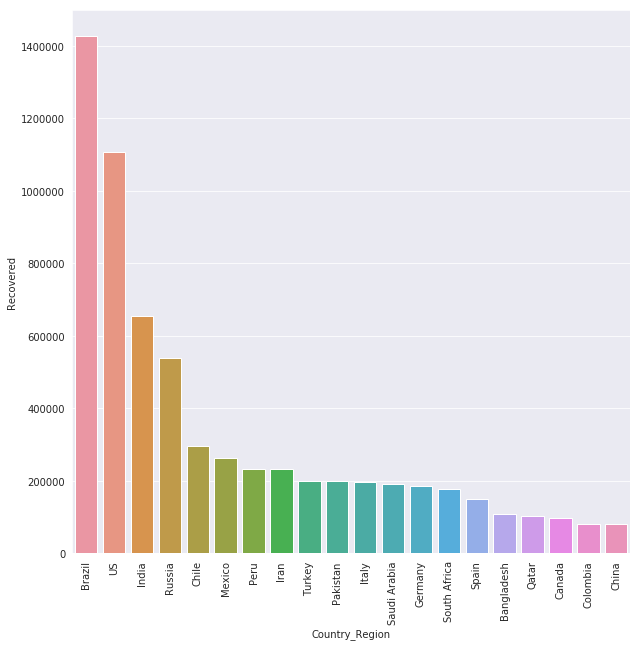

In [58]:
df3 = df1.loc[df1.date == yesterday].groupby(['Country_Region'])['Recovered'].sum()
top_20_countries_most_recovered_cases = df3.sort_values(ascending=False)[:20]
sns.barplot(x=top_20_countries_most_recovered_cases.index, y=top_20_countries_most_recovered_cases)
plt.xticks(rotation=90)
plt.show()

#### Top 10 Countries with Highest Death to Recovery Ratios

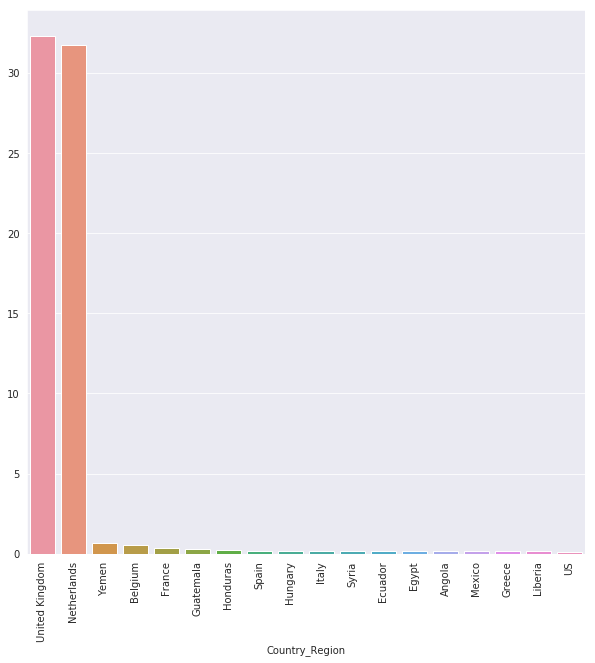

In [59]:
df3 = df1.loc[df1.date == yesterday].groupby('Country_Region').sum()
df3['Death_Recovery_Ratio'] = df3['Deaths'] / df3['Recovered']
top_20_highest_death_recovery_ratio = df3.sort_values('Death_Recovery_Ratio', ascending=False).head(20)
top_20_highest_death_recovery_ratio = top_20_highest_death_recovery_ratio[top_20_highest_death_recovery_ratio['Death_Recovery_Ratio'] != np.inf]
sns.barplot(x=top_20_highest_death_recovery_ratio.index, y=top_20_highest_death_recovery_ratio['Death_Recovery_Ratio'].values)
plt.xticks(rotation=90)
plt.show()

#### Note:

- Netherlands and UK have highest death to recovery rate i.e 1 person recovers when ~33 people die.

#### Comparing Top Countries Recovery Rates

In [60]:
countries = ['China', 'US', 'India', 'China', 'France', 'Italy', 'Iran', 'Belgium']

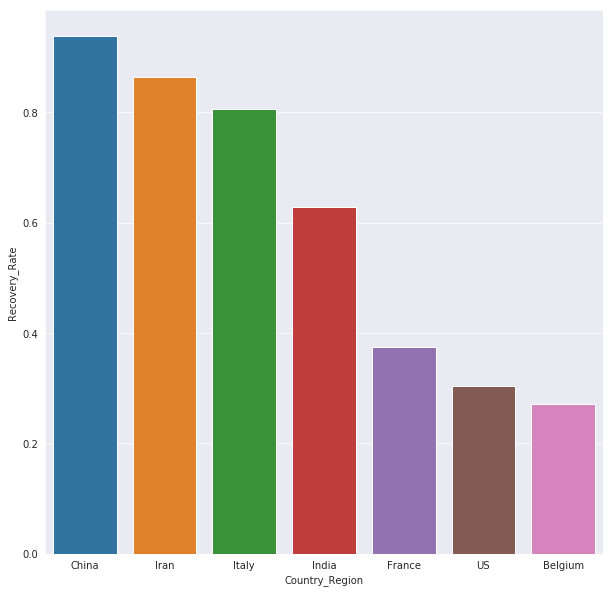

In [61]:
df_new = df1[df1.date == yesterday].groupby(['Country_Region']).sum()
df_new.loc[:, 'Recovery_Rate'] =  df_new['Recovered'] / df_new['Confirmed']
df_new = df_new.sort_values(by='Recovery_Rate', ascending=False)
df_recovery_rates = df_new.loc[countries].drop_duplicates().sort_values(by='Recovery_Rate', ascending=False)
sns.barplot(data=df_recovery_rates, x=df_recovery_rates.index, y='Recovery_Rate')
plt.show()

#### Top US Provinces with maximum impact

In [62]:
us_state_abbrev = """Alabama - AL

Alaska - AK

Arizona - AZ

Arkansas - AR

California - CA

Colorado - CO

Connecticut - CT

Delaware - DE

Florida - FL

Georgia - GA

Hawaii - HI

Idaho - ID

Illinois - IL

Indiana - IN

Iowa - IA

Kansas - KS

Kentucky - KY

Louisiana - LA

Maine - ME

Maryland - MD

Massachusetts - MA

Michigan - MI

Minnesota - MN

Mississippi - MS

Missouri - MO

Montana - MT

Nebraska - NE

Nevada - NV

New Hampshire - NH

New Jersey - NJ

New Mexico - NM

New York - NY

North Carolina - NC

North Dakota - ND

Ohio - OH

Oklahoma - OK

Oregon - OR

Pennsylvania - PA

Rhode Island - RI

South Carolina - SC

South Dakota - SD

Tennessee - TN

Texas - TX

Utah - UT

Vermont - VT

Virginia - VA

Washington - WA

West Virginia - WV

Wisconsin - WI

Wyoming - WY
"""

In [63]:
us_state_mapping = {}
pattern = re.compile(r'(\w+\s?\w+)\s+-\s+(\w+)', re.MULTILINE)
matches = pattern.finditer(us_state_abbrev) 
for match in matches:
    us_state_mapping[match.group(2)] = match.group(1)
    print(f"{match.group(2)} : {match.group(1)}")
us_state_mapping

AL : Alabama
AK : Alaska
AZ : Arizona
AR : Arkansas
CA : California
CO : Colorado
CT : Connecticut
DE : Delaware
FL : Florida
GA : Georgia
HI : Hawaii
ID : Idaho
IL : Illinois
IN : Indiana
IA : Iowa
KS : Kansas
KY : Kentucky
LA : Louisiana
ME : Maine
MD : Maryland
MA : Massachusetts
MI : Michigan
MN : Minnesota
MS : Mississippi
MO : Missouri
MT : Montana
NE : Nebraska
NV : Nevada
NH : New Hampshire
NJ : New Jersey
NM : New Mexico
NY : New York
NC : North Carolina
ND : North Dakota
OH : Ohio
OK : Oklahoma
OR : Oregon
PA : Pennsylvania
RI : Rhode Island
SC : South Carolina
SD : South Dakota
TN : Tennessee
TX : Texas
UT : Utah
VT : Vermont
VA : Virginia
WA : Washington
WV : West Virginia
WI : Wisconsin
WY : Wyoming


{'AL': 'Alabama',
 'AK': 'Alaska',
 'AZ': 'Arizona',
 'AR': 'Arkansas',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DE': 'Delaware',
 'FL': 'Florida',
 'GA': 'Georgia',
 'HI': 'Hawaii',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'IA': 'Iowa',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'ME': 'Maine',
 'MD': 'Maryland',
 'MA': 'Massachusetts',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MS': 'Mississippi',
 'MO': 'Missouri',
 'MT': 'Montana',
 'NE': 'Nebraska',
 'NV': 'Nevada',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NY': 'New York',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VT': 'Vermont',
 'VA': 'Virginia',
 'WA': 'Washington',
 'WV': 'West Virginia',
 'WI': 'Wisconsin',
 'WY': 'Wyoming'}

In [64]:
df_us = df1.loc[(df1.Country_Region == 'US')]
df_us.loc[:, 'state'] = df_us.Province_State.str.strip().str.split(',', n=1).apply(lambda x: x[-1])

/home/akash/Dev/python/venv/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [65]:
def map_us_state_abbreviation_to_state_name(abbrev):
    abbrev = abbrev.strip()
    if abbrev in us_state_mapping:
        return us_state_mapping[abbrev]
    elif 'Diamond Princess' in abbrev or 'Recovered' in abbrev:
        return np.nan
    
    else:
        return abbrev

#### Deaths

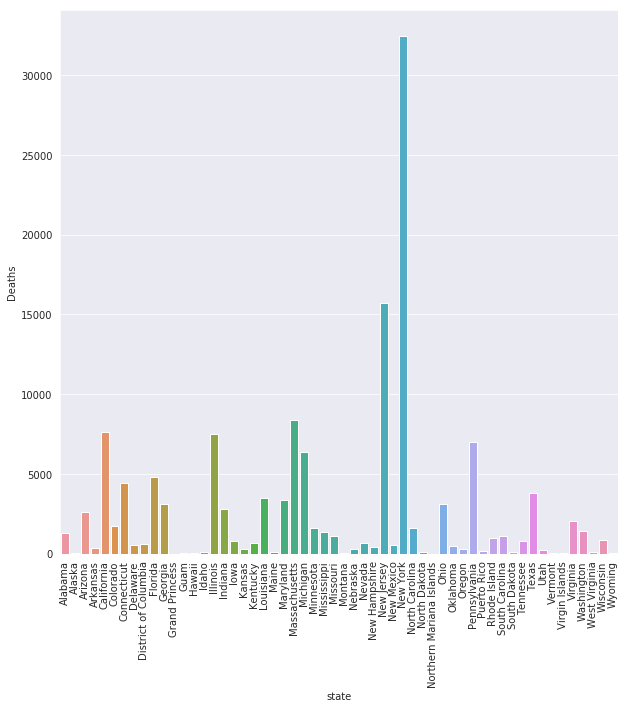

In [66]:
df_us.loc[:, 'state'] = df_us['state'].map(map_us_state_abbreviation_to_state_name)
df_us = df_us.dropna(subset=['state'])
df5 = df_us[df_us.date == yesterday].groupby('state').sum()
sns.barplot(x=df5.index, y=df5['Deaths'])
plt.xticks(rotation=90)
plt.show()

#### Active Cases 

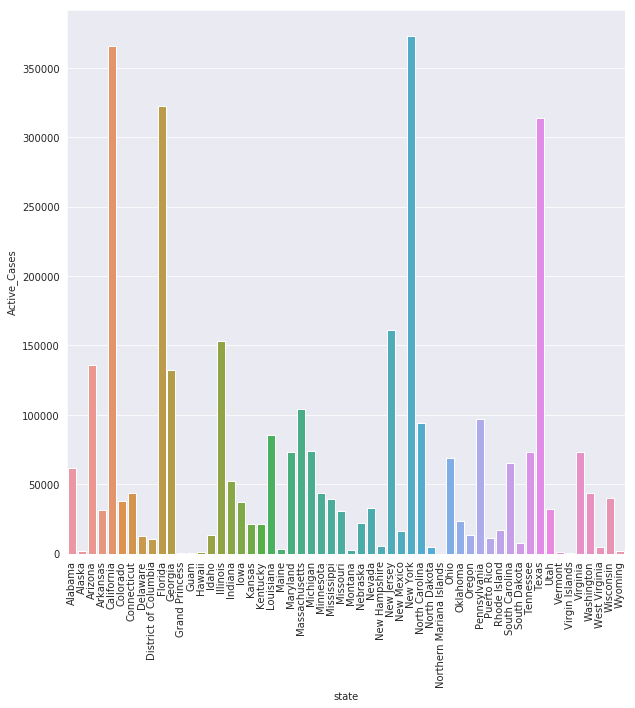

In [67]:
sns.barplot(x=df5.index, y=df5['Active_Cases'])
plt.xticks(rotation=90)
plt.show()

### Global Confirmed Cases

In [68]:
base_dir = '../data/Global/csse_covid_19_time_series/'
abs_path = os.path.abspath(base_dir)
files = os.listdir(abs_path)
csv_files = filter(lambda file: '.csv' in file, files)
csv_abs_path = [os.path.join(abs_path, csv_file) for csv_file in csv_files]
csv_abs_path = sorted(csv_abs_path)
columns = []
with open('../data/Global/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    columns = next(spamreader) 
    l = [i for i in spamreader]

In [69]:
df_global_confirmed = pd.DataFrame(l, columns=columns)
df_global_confirmed_min = df_global_confirmed.drop(columns=['Province/State', 'Lat', 'Long'])
list_of_columns = [col for col in df_global_confirmed_min.columns if 'Country' not in col]
df_trans = df_global_confirmed_min.transpose()
df_trans.columns = df_trans.iloc[0, :]
df_trans = df_trans.iloc[1:, :]
df_trans = df_trans.astype(np.int)
df_trans.index = pd.to_datetime(df_trans.index)

#### Cleaning data for UK and Netherlands

In [70]:
df_uk = df_trans['United Kingdom']
flag = [False, False, False, False, False, False, True, False, False, False, False, False]
df_trans['UK'] = df_uk.loc[:, flag]
df_netherlands = df_trans['Netherlands']
flag = [False, False, False, True]
df_trans['Holland'] = df_netherlands.loc[:, flag]

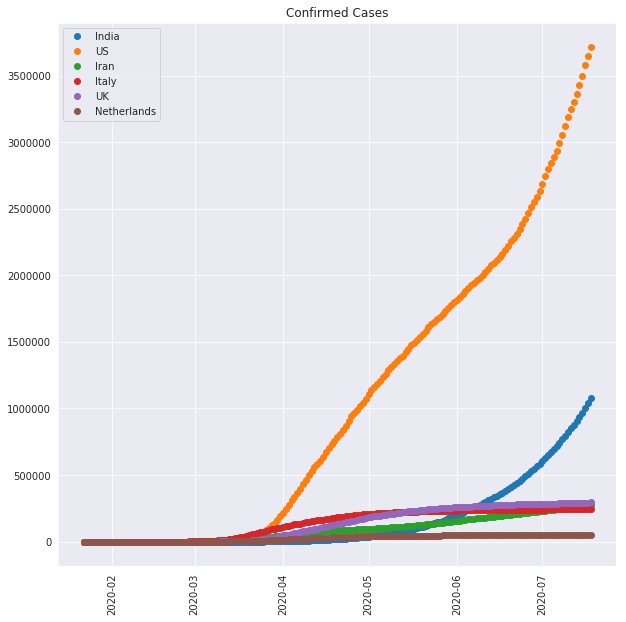

In [71]:
plt.plot_date(x=df_trans.index, y=df_trans['India'], label='India')
plt.plot_date(x=df_trans.index, y=df_trans['US'], label='US')
plt.plot_date(x=df_trans.index, y=df_trans['Iran'], label='Iran')
plt.plot_date(x=df_trans.index, y=df_trans['Italy'], label='Italy')
plt.plot_date(x=df_trans.index, y=df_trans['UK'], label='UK')
plt.plot_date(x=df_trans.index, y=df_trans['Holland'], label='Netherlands')
plt.xticks(rotation=90)
plt.title('Confirmed Cases')
plt.legend()
plt.show()

### Global Deaths

In [72]:
columns = []
with open('../data/Global/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    columns = next(spamreader) 
    l = [i for i in spamreader]
df_global_deaths = pd.DataFrame(l, columns=columns)
df_global_deaths_min = df_global_deaths.drop(columns=['Province/State', 'Lat', 'Long'])
list_of_columns = [col for col in df_global_confirmed_min.columns if 'Country' not in col]
df_trans_deaths = df_global_deaths_min.transpose()
df_trans_deaths.columns = df_trans_deaths.iloc[0, :]
df_trans_deaths = df_trans_deaths.iloc[1:, :]
df_trans_deaths = df_trans_deaths.astype(np.int)
df_trans_deaths.index = pd.to_datetime(df_trans_deaths.index)

#### Cleaning data for UK and Netherlands

In [73]:
df_trans_deaths.columns[df_trans_deaths.columns == 'Netherlands']
df_uk = df_trans_deaths['United Kingdom']
flag = [False, False, False, False, False, False, True, False, False, False, False, False]
df_trans_deaths['UK'] = df_uk.loc[:, flag]
df_netherlands = df_trans_deaths['Netherlands']
flag = [False, False, False, True]
df_trans_deaths['Holland'] = df_netherlands.loc[:, flag]

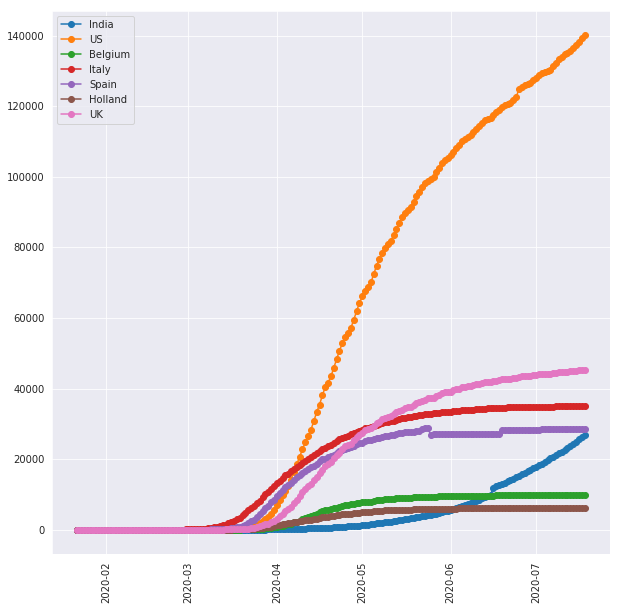

In [74]:
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['India'], label='India', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['US'], label='US', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['Belgium'], label='Belgium', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['Italy'], label='Italy', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['Spain'], label='Spain', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['Holland'], label='Holland', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['UK'], label='UK', linestyle='solid')
# plt.plot_date(x=df_trans.index, y=df_trans['China'], label='China', linestyle='solid')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Global Recovery

In [75]:
columns = []
with open('../data/Global/csse_covid_19_time_series/time_series_covid19_recovered_global.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    columns = next(spamreader) 
    l = [i for i in spamreader]
df_global_recovered = pd.DataFrame(l, columns=columns)
df_global_recovered_min = df_global_recovered.drop(columns=['Province/State', 'Lat', 'Long'])
list_of_columns = [col for col in df_global_recovered_min.columns if 'Country' not in col]
df_trans_recovered = df_global_recovered_min.transpose()
df_trans_recovered.columns = df_trans_recovered.iloc[0, :]
df_trans_recovered = df_trans_recovered.iloc[1:, :]
df_trans_recovered = df_trans_recovered.astype(np.int)
df_trans_recovered.index = pd.to_datetime(df_trans_recovered.index)

In [76]:
df_trans_recovered.columns[df_trans_recovered.columns == 'Netherlands']
df_uk = df_trans_recovered['United Kingdom']
flag = [False, False, False, False, False, False, True, False, False, False, False, False]
df_trans_recovered['UK'] = df_uk.loc[:, flag]
df_netherlands = df_trans_recovered['Netherlands']
flag = [False, False, False, True]
df_trans_recovered['Holland'] = df_netherlands.loc[:, flag]

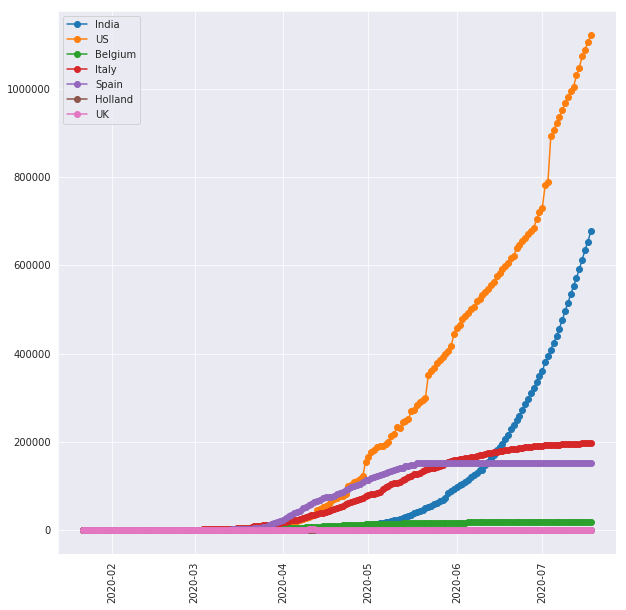

In [77]:
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['India'], label='India', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['US'], label='US', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['Belgium'], label='Belgium', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['Italy'], label='Italy', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['Spain'], label='Spain', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['Holland'], label='Holland', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['UK'], label='UK', linestyle='solid')
# plt.plot_date(x=df_trans.index, y=df_trans['China'], label='China', linestyle='solid')
# plt.plot_date(x=df_trans.index, y=df_trans['United Kingdom'], label='UK', linestyle='solid')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Comparing Confirmed vs Recovered vs Deaths for selected countries

### India

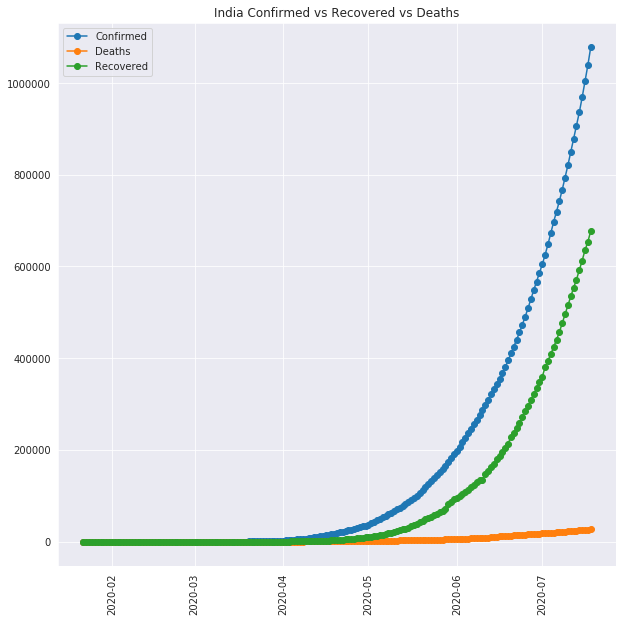

In [78]:
plt.plot_date(x=df_trans.index, y=df_trans['India'], label='Confirmed', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['India'], label='Deaths', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['India'], label='Recovered', linestyle='solid')

plt.xticks(rotation=90)
plt.legend()
plt.title('India Confirmed vs Recovered vs Deaths')
plt.show()

### UK

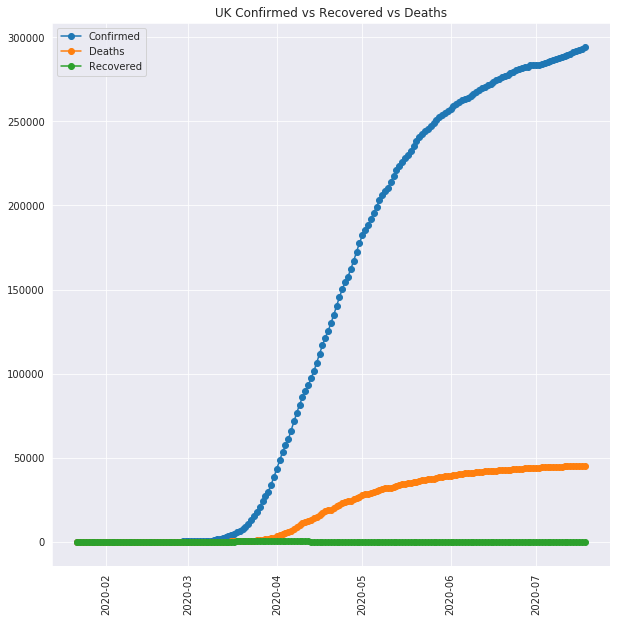

In [79]:
plt.plot_date(x=df_trans.index, y=df_trans['UK'], label='Confirmed', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['UK'], label='Deaths', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['UK'], label='Recovered', linestyle='solid')

plt.xticks(rotation=90)
plt.legend()
plt.title('UK Confirmed vs Recovered vs Deaths')
plt.show()

### US

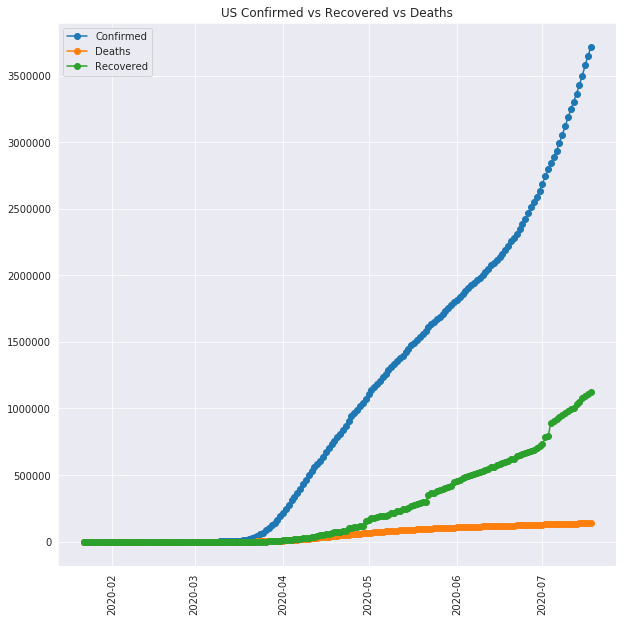

In [80]:
plt.plot_date(x=df_trans.index, y=df_trans['US'], label='Confirmed', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['US'], label='Deaths', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['US'], label='Recovered', linestyle='solid')

plt.xticks(rotation=90)
plt.legend()
plt.title('US Confirmed vs Recovered vs Deaths')
plt.show()

### Holland

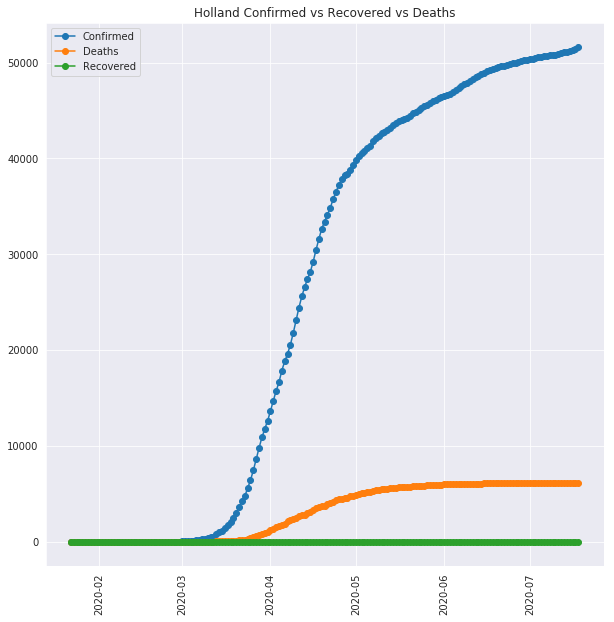

In [81]:
plt.plot_date(x=df_trans.index, y=df_trans['Holland'], label='Confirmed', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['Holland'], label='Deaths', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['Holland'], label='Recovered', linestyle='solid')

plt.xticks(rotation=90)
plt.legend()
plt.title('Holland Confirmed vs Recovered vs Deaths')
plt.show()

### India's fight against corona virus

### Active Cases

In [82]:
df_india = df1.loc[df1.Country_Region == 'India'].groupby(['Country_Region', 'date']).sum().reset_index()

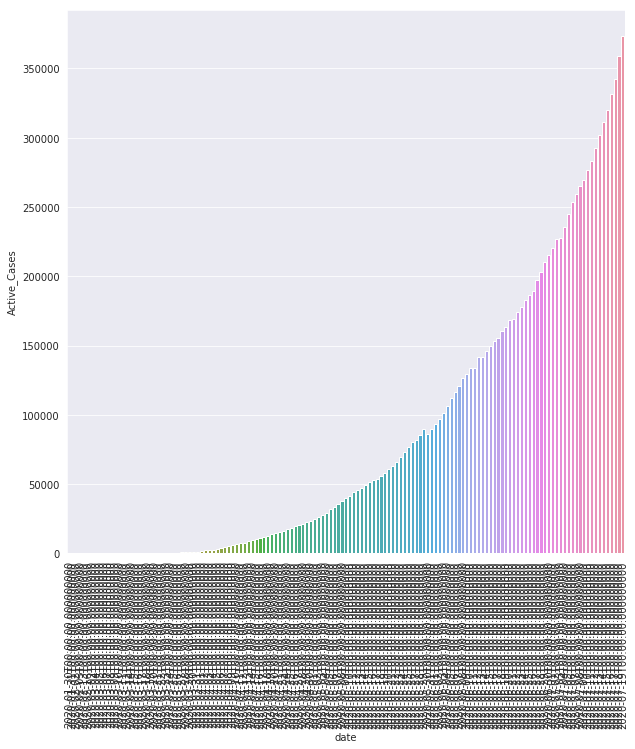

In [83]:
sns.barplot(x='date', y='Active_Cases', data=df_india)
plt.xticks(rotation=90)
# plt.yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000])
plt.show()

### Deaths

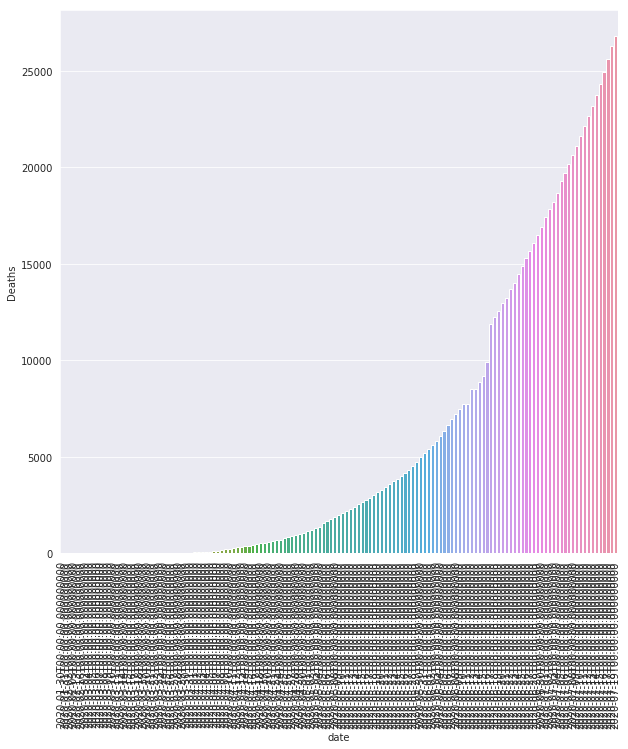

In [84]:
sns.barplot(x='date', y='Deaths', data=df_india)
plt.xticks(rotation=90)
# plt.yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000])
plt.show()

### Recovery

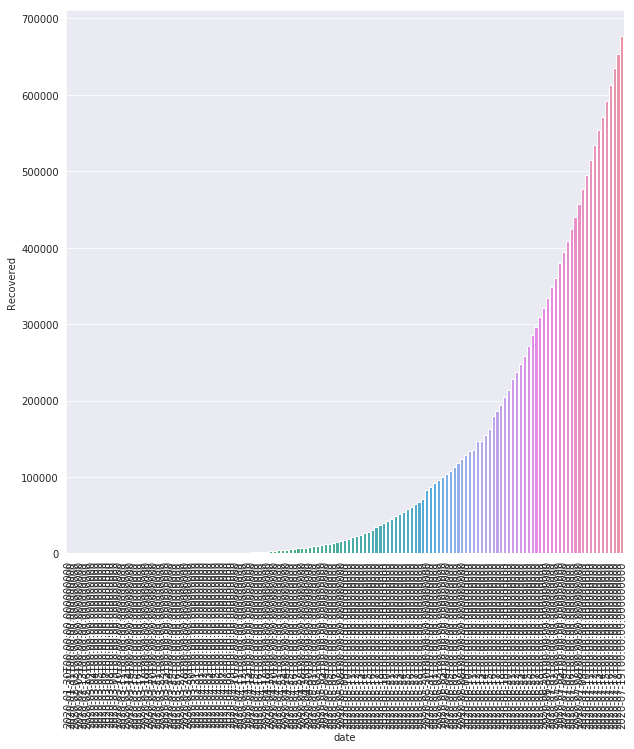

In [85]:
sns.barplot(x='date', y='Recovered', data=df_india)
plt.xticks(rotation=90)
# plt.yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000])
plt.show()

## Comparing India and New York Graphs

- Is India following New York trajectory?

#### India vs New York Confirmed Cases

In [86]:
columns = []
with open('../data/Global/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    columns = next(spamreader) 
    l = [i for i in spamreader]

In [87]:
df_us_confirmed = pd.DataFrame(l, columns=columns)
df_us_confirmed_min = df_us_confirmed.drop(columns=['Country_Region', 'Lat', 'Long_', 'UID', 'iso2', 'iso3', 'code3',
                                                   'FIPS','Admin2', 'Combined_Key'])
list_of_columns = [col for col in df_us_confirmed_min.columns if 'State' not in col]
df_trans_us_confirmed = df_us_confirmed_min.transpose()
df_trans_us_confirmed.columns = df_trans_us_confirmed.iloc[0, :]
df_trans_us_confirmed = df_trans_us_confirmed.iloc[1:, :]
df_trans_us_confirmed = df_trans_us_confirmed.astype(np.int)
df_trans_us_confirmed.index = pd.to_datetime(df_trans_us_confirmed.index)
df_trans_us_confirmed['NY'] = df_trans_us_confirmed['New York'].agg(np.sum, axis=1)

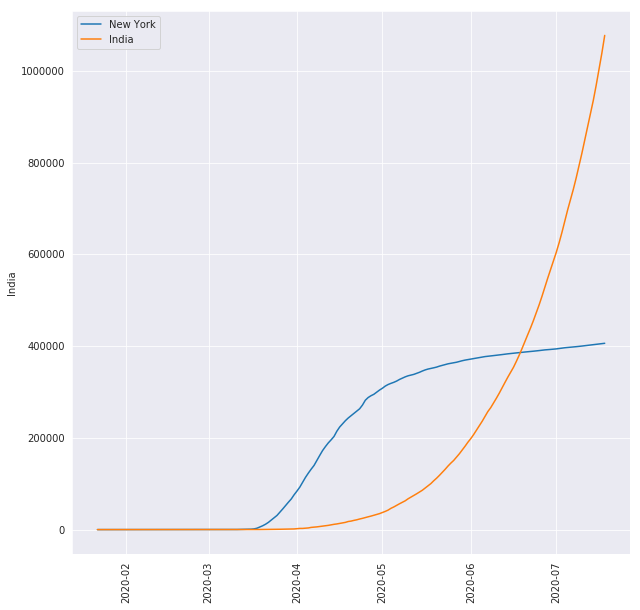

In [88]:
sns.lineplot(x=df_trans_us_confirmed.index, y=df_trans_us_confirmed['NY'], label='New York')
sns.lineplot(x=df_trans.index, y=df_trans['India'], label='India')
plt.xticks(rotation=90)
plt.legend()
plt.show()

#### Yes, India's trajectory is similar to New York. Only difference is that New York has reached the peak, whereas India is still on the rise.

#### India vs New York Deaths

In [89]:
columns = []
with open('../data/Global/csse_covid_19_time_series/time_series_covid19_deaths_US.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    columns = next(spamreader) 
    l = [i for i in spamreader]

In [90]:
df_us_deaths = pd.DataFrame(l, columns=columns)
df_us_deaths_min = df_us_deaths.drop(columns=['Country_Region', 'Lat', 'Long_', 'UID', 'iso2', 'iso3', 'code3',
                                                   'FIPS','Admin2', 'Combined_Key', 'Population'])
list_of_columns = [col for col in df_us_deaths_min.columns if 'State' not in col]
df_trans_us_deaths = df_us_deaths_min.transpose()
df_trans_us_deaths.columns = df_trans_us_deaths.iloc[0, :]
df_trans_us_deaths = df_trans_us_deaths.iloc[1:, :]
df_trans_us_deaths = df_trans_us_deaths.astype(np.int)
df_trans_us_deaths.index = pd.to_datetime(df_trans_us_deaths.index)
df_trans_us_deaths['NY'] = df_trans_us_deaths['New York'].agg(np.sum, axis=1)

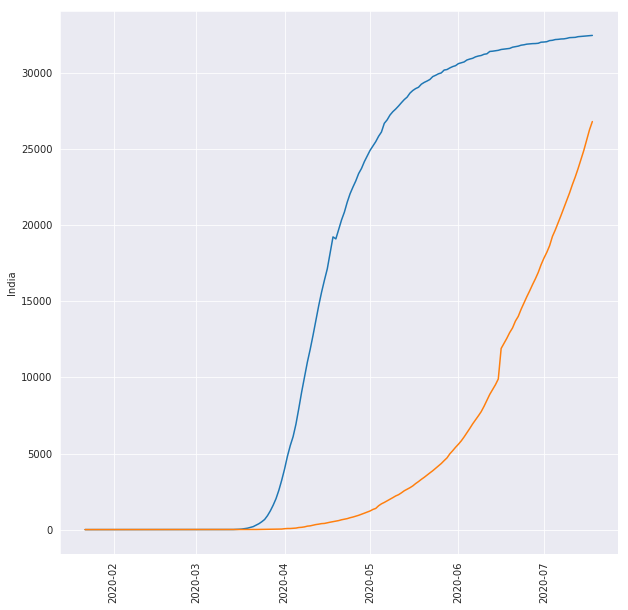

In [91]:
sns.lineplot(x=df_trans_us_deaths.index, y=df_trans_us_deaths['NY'])
sns.lineplot(x=df_trans_deaths.index, y=df_trans_deaths['India'])
plt.xticks(rotation=90)
plt.show()

### Time Series Forecasting using ARIMA model


In [92]:
def get_list_of_arma_model_parameters(df, no_of_lags):
    """ Helper Function to return list of tuple of ARMA params like (ar, ma, aic, bic)"""
    list_tup = []
    for i in range(10):
        for j in range(10):
            try:
                ARIMA_model = ARIMA(df, order=(i, no_of_lags, j)).fit(transparams=False)
                t = tuple([i, j, ARIMA_model.aic, ARIMA_model.bic])
                list_tup.append(t)
            except Exception as e:
                print(e)
    return list_tup

In [93]:
def get_best_ar_ma_value(list_of_tup):
    """ Helper Function to return best fit params from list of tuple of ARMA params like (ar, ma, aic, bic)"""
    least_bic = list_tup[0][3]
    best_params = list_tup[0]
    list_of_best_params = []
    for tup in list_of_tup:
        if tup[3] < least_bic:
            best_params = tup
            least_bic = tup[3]
    return best_params

### US Deaths

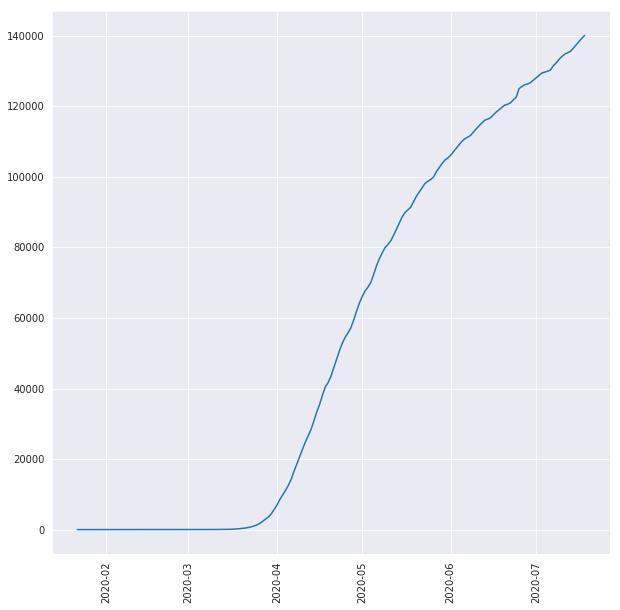

In [94]:
df_trans_deaths_us = df_trans_deaths[['US']]
plt.plot(df_trans_deaths_us)
plt.xticks(rotation=90)
plt.show()

In [95]:
df_us1 = df_trans_deaths_us.diff().fillna(df_trans_deaths_us)
df_us1.tail()

Country/Region,US
2020-07-14,900.0
2020-07-15,949.0
2020-07-16,943.0
2020-07-17,908.0
2020-07-18,853.0


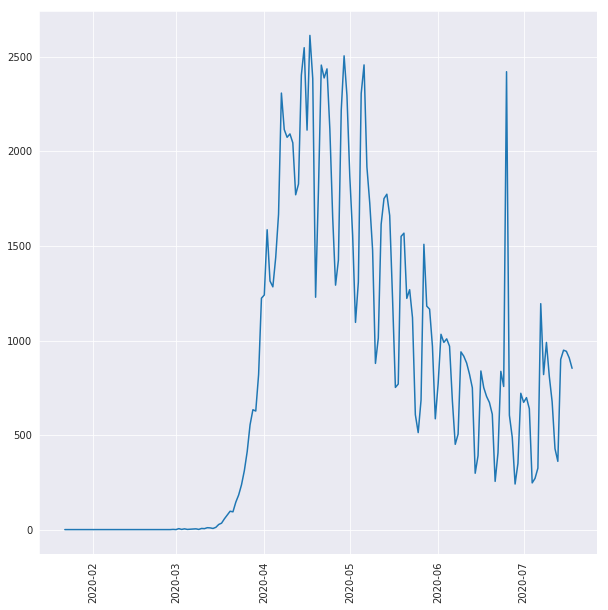

In [96]:
plt.plot(df_us1)
plt.xticks(rotation=90)
plt.show()

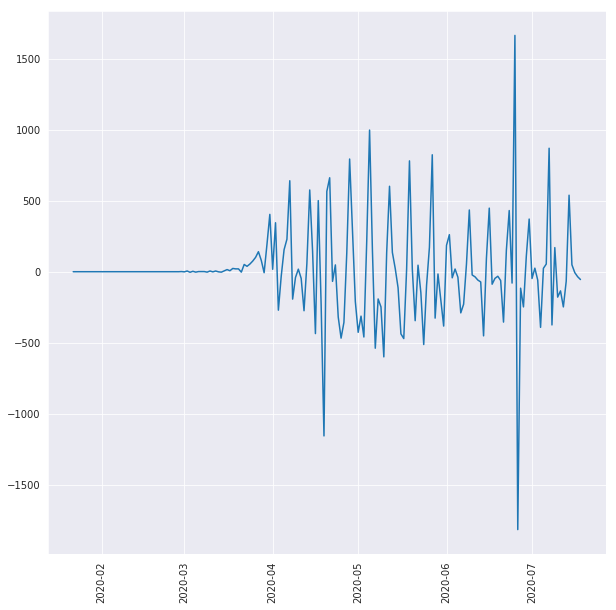

In [97]:
df_us2 = df_us1.diff().fillna(df_us1)
plt.plot(df_us2)
plt.xticks(rotation=90)
plt.show()

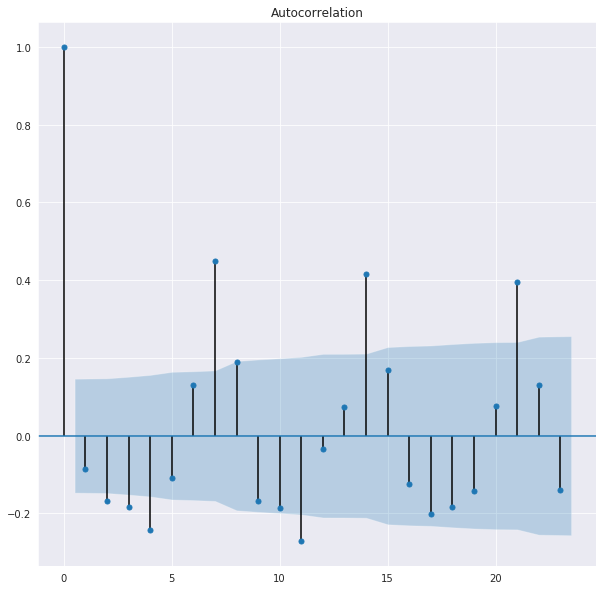

In [98]:
plot_acf(df_us2)
plt.show()

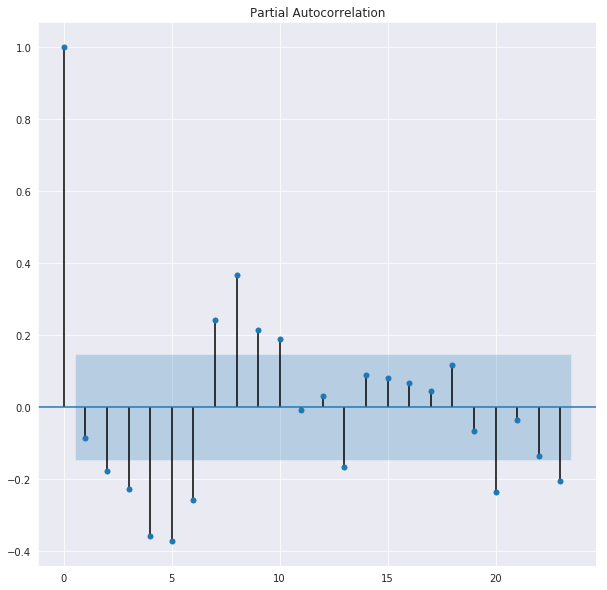

In [99]:
plot_pacf(df_us2)
plt.show()

In [100]:
list_tup = get_list_of_arma_model_parameters(df_trans_deaths_us, 2)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was pr

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to c

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not 

In [101]:
ar, ma, aic, bic = get_best_ar_ma_value(list_tup)

In [102]:
ARIMA_model = ARIMA(df_trans_deaths_us, order=(ar, 2, ma)).fit(transparams=False)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [103]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D2.US   No. Observations:                  177
Model:                 ARIMA(2, 2, 5)   Log Likelihood               -1225.379
Method:                       css-mle   S.D. of innovations                nan
Date:                Sun, 19 Jul 2020   AIC                           2468.757
Time:                        16:06:27   BIC                           2497.343
Sample:                    01-24-2020   HQIC                          2480.351
                         - 07-18-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.1336     10.076      0.509      0.610     -14.615      24.882
ar.L1.D2.US     1.2453      0.017     74.581      0.000       1.213       1.278
ar.L2.D2.US    -0.9822      0.013    -76.128      0.000      -1.007      -0.957
ma.L1.D2.US    -1.7924      0.075    -23.927      0.000      -1.939      -1.646
ma.L2.D2.US     1.5346      0.153     10.034      0.000       1.235       1.834
ma.L3.D2.US    -0.2848      0.188     -1.515      0.130      -0.653       0.084
ma.L4.D2.US    -0.2812      0.148     -1.905      0.057      -0.570       0.008
ma.L5.D2.US     0.2305      0.070      3.312      0.001       0.094       0.367
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6340           -0.7850j            1.0090           -0.1419
AR.2            0.6340           +0.7850j            1.0090            0.1419
MA.1           -2.0642           -0.0000j            2.0642           -0.5000
MA.2            0.7050           -1.0001j            1.2236           -0.1523
MA.3            0.7050           +1.0001j            1.2236            0.1523
MA.4            0.9370           -0.7251j            1.1848           -0.1048
MA.5            0.9370           +0.7251j            1.1848            0.1048
-----------------------------------------------------------------------------
"""

In [104]:
arma_predict = ARIMA_model.predict('2020-06-05', '2020-07-15', typ='levels')

In [105]:
arma_predict

2020-06-05    110257.931684
2020-06-06    110891.423756
2020-06-07    111315.865280
2020-06-08    111743.004769
2020-06-09    112430.329206
2020-06-10    113691.942569
2020-06-11    114627.886183
2020-06-12    115388.405723
2020-06-13    115986.081578
2020-06-14    116662.598946
2020-06-15    116878.842069
2020-06-16    117447.320952
2020-06-17    118503.616968
2020-06-18    119204.560114
2020-06-19    119751.615047
2020-06-20    120201.953056
2020-06-21    120750.757783
2020-06-22    120980.144289
2020-06-23    121607.717139
2020-06-24    122690.704775
2020-06-25    123431.117925
2020-06-26    126501.787952
2020-06-27    126314.331076
2020-06-28    126890.117831
2020-06-29    126840.642606
2020-06-30    127532.294558
2020-07-01    128497.195752
2020-07-02    129047.575076
2020-07-03    129362.605618
2020-07-04    129579.145783
2020-07-05    129591.315711
2020-07-06    130113.190439
2020-07-07    130805.317155
2020-07-08    132645.973388
2020-07-09    133330.524502
2020-07-10    134249

In [106]:
undiff1 = df_us2.cumsum().fillna(df_us2)
undiff2 = df_us1.cumsum().fillna(df_us1)

### Mean Absolute Error for Forecast Evaluation

In [107]:
arma_predict2 = ARIMA_model.predict('2020-01-24', '2020-07-25', typ='levels')
ser2 = arma_predict2

In [108]:
ser2.diff()

2020-01-24            NaN
2020-01-25       0.203320
2020-01-26       0.819590
2020-01-27       1.540915
2020-01-28       3.352293
2020-01-29       3.982184
2020-01-30       2.146181
2020-01-31      -2.390822
2020-02-01      -4.090051
2020-02-02      -2.632764
2020-02-03      -0.787839
2020-02-04       0.481233
2020-02-05       1.153951
2020-02-06       1.157964
2020-02-07       0.516495
2020-02-08      -0.281889
2020-02-09      -0.642535
2020-02-10      -0.516844
2020-02-11      -0.211192
2020-02-12       0.034290
2020-02-13       0.140351
2020-02-14       0.135359
2020-02-15       0.088177
2020-02-16       0.048031
2020-02-17       0.021905
                 ...     
2020-07-01     964.901195
2020-07-02     550.379324
2020-07-03     315.030542
2020-07-04     216.540165
2020-07-05      12.169928
2020-07-06     521.874728
2020-07-07     692.126715
2020-07-08    1840.656233
2020-07-09     684.551114
2020-07-10     919.465011
2020-07-11     429.216569
2020-07-12     645.673746
2020-07-13  

### Note:

- The model predicted number of deaths on 13th June as 648.
- Actual number of deaths on 13th June: 654

#### Note the predicted trajectory in blue.

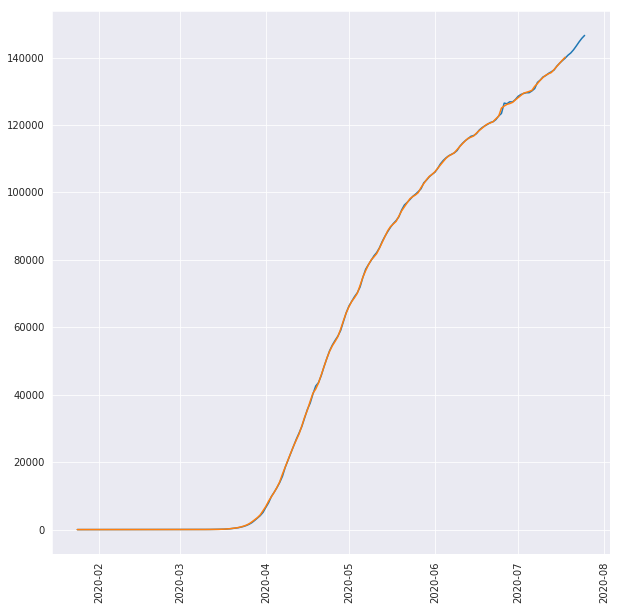

In [109]:
actual = df_trans_deaths_us.loc['2020-01-24':, :]
plt.plot(ser2)
plt.plot(actual)
plt.xticks(rotation=90)
plt.show()

# India

### India Deaths

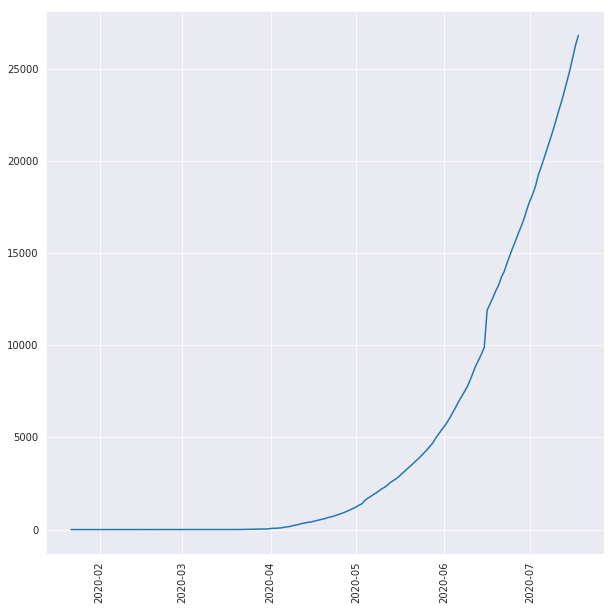

In [110]:
df_trans_deaths_ind = df_trans_deaths[['India']]
plt.plot(df_trans_deaths_ind)
plt.xticks(rotation=90)
plt.show()

In [111]:
temp = np.log(df_trans_deaths_ind)
temp = temp[temp.India != -np.inf]

/home/akash/Dev/python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [112]:
temp.head()

Country/Region,India
2020-03-11,0.000000
2020-03-12,0.000000
2020-03-13,0.693147
2020-03-14,0.693147
2020-03-15,0.693147


In [113]:
df_deaths_ind = df_trans_deaths_ind

In [114]:
df_trans_deaths_ind = temp[temp.India != -np.inf]

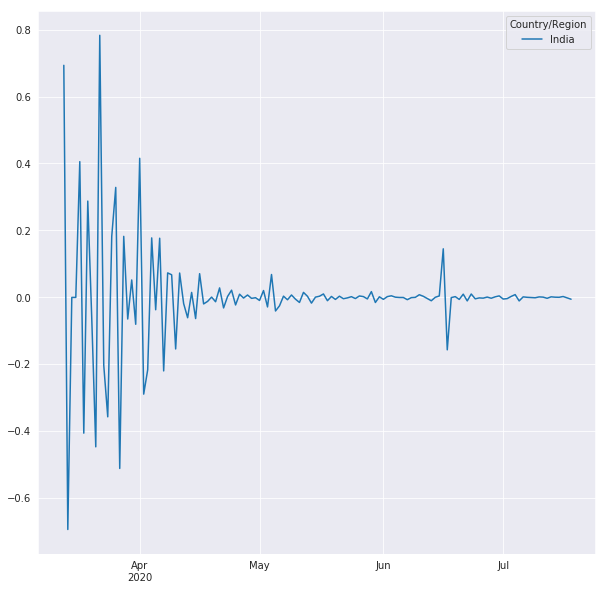

In [115]:
df_trans_deaths_ind.diff().dropna().diff().dropna().plot()

In [116]:
df_ind1 = df_trans_deaths_ind.diff().fillna(df_trans_deaths_ind)
df_ind1.tail()

Country/Region,India
2020-07-14,0.024233
2020-07-15,0.024583
2020-07-16,0.027241
2020-07-17,0.025871
2020-07-18,0.020457


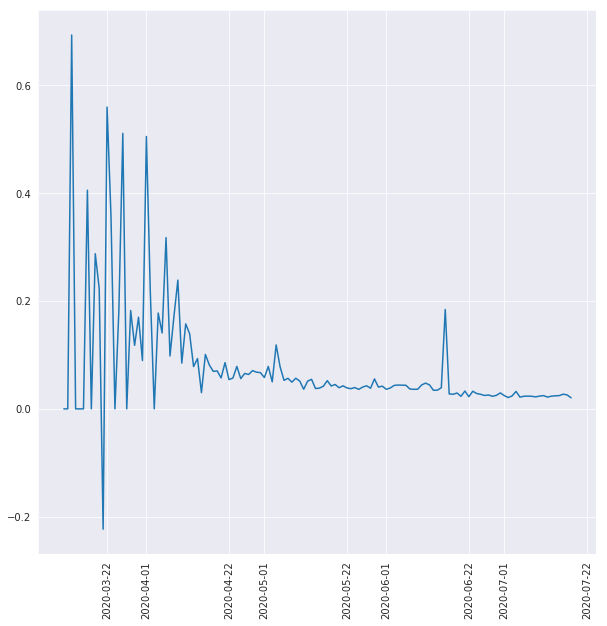

In [117]:
plt.plot(df_ind1)
plt.xticks(rotation=90)
plt.show()

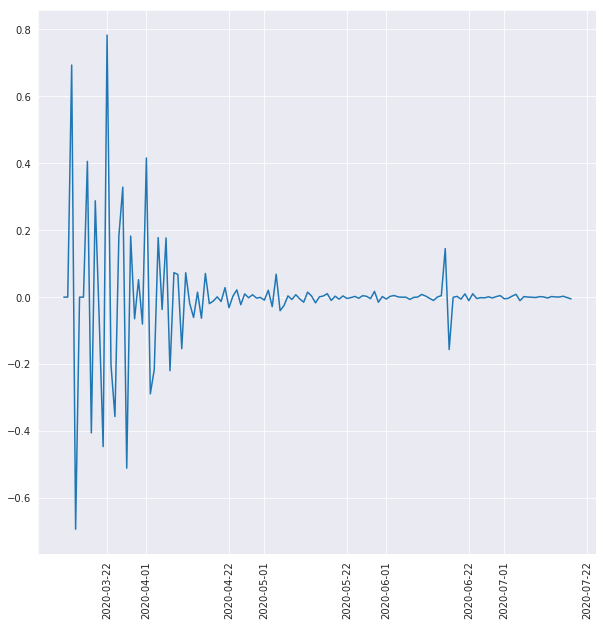

In [118]:
df_ind2 = df_ind1.diff().fillna(df_ind1)
plt.plot(df_ind2)
plt.xticks(rotation=90)
plt.show()

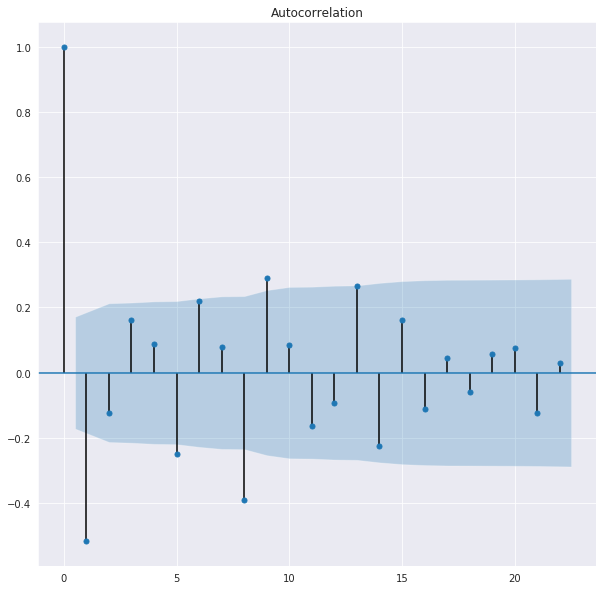

In [119]:
plot_acf(df_ind2)
plt.show()

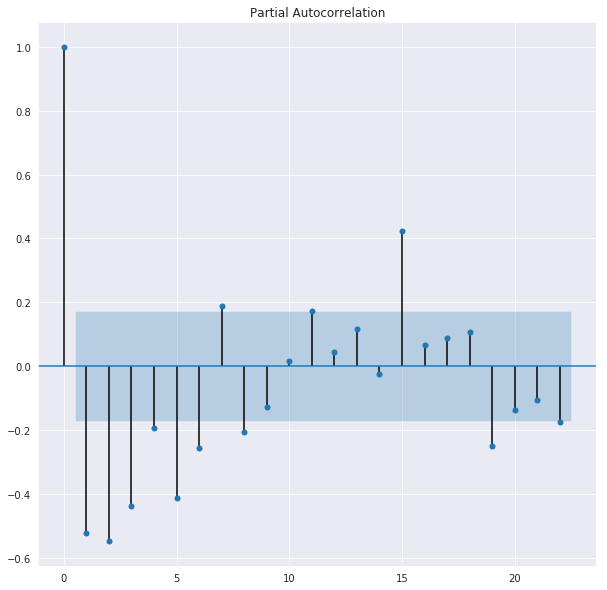

In [120]:
plot_pacf(df_ind2)
plt.show()

In [121]:
list_tup = get_list_of_arma_model_parameters(df_deaths_ind, 2)
ar, ma, aic, bic = get_best_ar_ma_value(list_tup)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are 

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so 

In [122]:
ARIMA_model = ARIMA(df_deaths_ind, order=(ar, 2, ma)).fit(transparams=False)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [123]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.India   No. Observations:                  177
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -1118.602
Method:                       css-mle   S.D. of innovations            133.861
Date:                Sun, 19 Jul 2020   AIC                           2243.204
Time:                        16:07:47   BIC                           2252.733
Sample:                    01-24-2020   HQIC                          2247.069
                         - 07-18-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.3830      1.336      2.532      0.011       0.765       6.001
ma.L1.D2.India    -0.8725      0.034    -25.723      0.000      -0.939      -0.806
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.1462           +0.0000j            1.1462            0.0000
-----------------------------------------------------------------------------
"""

In [124]:
arma_predict = ARIMA_model.predict('2020-06-05', '2020-08-15', typ='levels')

In [125]:
undiff1 = df_ind2.cumsum().fillna(df_ind2)
undiff2 = df_ind1.cumsum().fillna(df_ind1)

### Mean Absolute Error for Forecast Evaluation

In [126]:
arma_predict2 = ARIMA_model.predict('2020-01-24', '2020-07-15', typ='levels')
ser2 = arma_predict2

In [127]:
ser2.diff()

2020-01-24           NaN
2020-01-25      1.675890
2020-01-26      1.645229
2020-01-27      1.600622
2020-01-28      1.543614
2020-01-29      1.476085
2020-01-30      1.400125
2020-01-31      1.317909
2020-02-01      1.231579
2020-02-02      1.143148
2020-02-03      1.054427
2020-02-04      0.966975
2020-02-05      0.882078
2020-02-06      0.800743
2020-02-07      0.723716
2020-02-08      0.651500
2020-02-09      0.584394
2020-02-10      0.522517
2020-02-11      0.465851
2020-02-12      0.414267
2020-02-13      0.367557
2020-02-14      0.325454
2020-02-15      0.287658
2020-02-16      0.253850
2020-02-17      0.223702
                 ...    
2020-06-21    285.835014
2020-06-22    445.130806
2020-06-23    295.154741
2020-06-24    469.812419
2020-06-25    416.205601
2020-06-26    404.031757
2020-06-27    378.477424
2020-06-28    408.496999
2020-06-29    374.863228
2020-06-30    418.363778
2020-07-01    518.666152
2020-07-02    434.870018
2020-07-03    372.745799
2020-07-04    444.576691


### Note:

- The model predicted number of deaths on 13th June as 648.
- Actual number of deaths on 13th June: 654

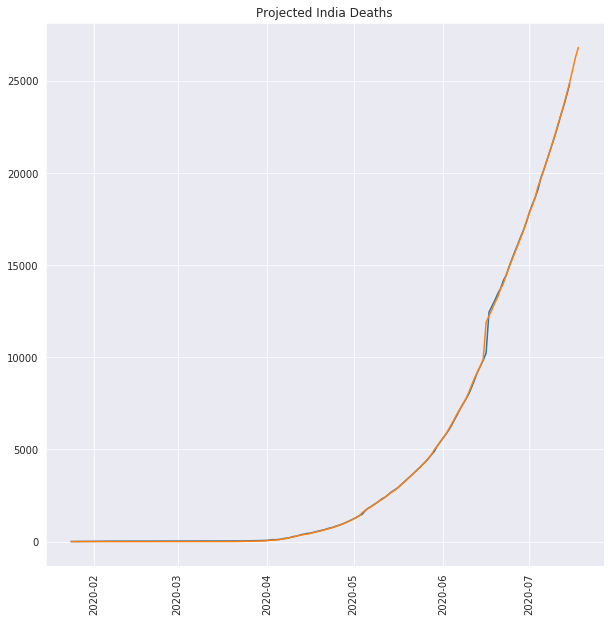

In [128]:
actual = df_deaths_ind.loc['2020-01-24':, :]
plt.plot(ser2)
plt.plot(actual)
plt.xticks(rotation=90)
plt.title('Projected India Deaths')
plt.show()

In [129]:
df_new = pd.DataFrame(actual)

In [130]:
df_new['predicted'] = ser2

In [131]:
df_new = df_new.rename(columns={"India":"actual"})

In [132]:
df_new.loc[:, 'error'] = np.absolute(df_new.predicted - df_new.actual)

In [133]:
df_new.tail()

Country/Region,actual,predicted,error
2020-07-14,24309,24243.230285,65.769715
2020-07-15,24914,24836.999869,77.000131
2020-07-16,25602,NaN,NaN
2020-07-17,26273,NaN,NaN
2020-07-18,26816,NaN,NaN


In [134]:
df_new.loc[:, 'error_squared'] = np.square(df_new.predicted - df_new.actual)

In [135]:
sum(df_new.error_squared) / len(df_new)

nan

In [136]:
np.sqrt(sum(df_new.error_squared) / len(df_new))

nan

In [137]:
root_mean_square_error = np.sqrt(sum(df_new.error_squared) / len(df_new))

In [138]:
root_mean_square_error

nan

### Forecast India's Active Cases

In [139]:
df_india_active = pd.DataFrame(df_trans.loc[:, 'India'])
df_india_active = df_india_active.rename({"India": 'Confirmed'}, axis='columns')

In [140]:
df_india_active['Recovered'] = df_trans_recovered.loc[:, 'India']

In [141]:
df_india_active['Active'] = df_india_active['Confirmed'] - df_india_active['Recovered']

In [142]:
df_india_active = df_india_active[['Active']]

In [143]:
df_temp = df_india_active
df_temp['exp'] = np.log10(df_india_active['Active'])

/home/akash/Dev/python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [144]:
df_temp = df_temp[df_temp.exp != -np.inf]

In [145]:
df_temp.tail()

,Active,exp
2020-07-14,344149,5.536747
2020-07-15,356089,5.551559
2020-07-16,368075,5.565936
2020-07-17,385333,5.585836
2020-07-18,400358,5.602449


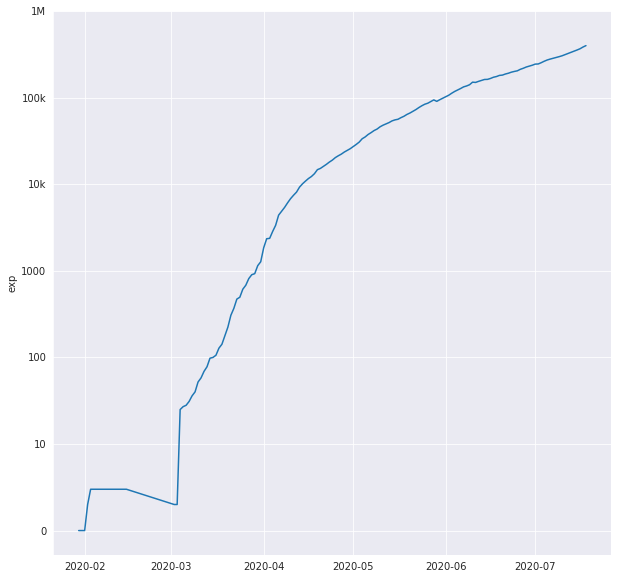

In [146]:
sns.lineplot(df_temp.index, df_temp.exp)
plt.yticks([0, 1, 2, 3, 4, 5, 6], ['0', '10', '100', '1000', '10k', '100k', '1M'])
plt.show()

In [147]:
# df_india_active = np.log(df_india_active)
# df_india_active = df_india_active[df_india_active != -np.inf]
df_india_active = df_india_active[['Active']]

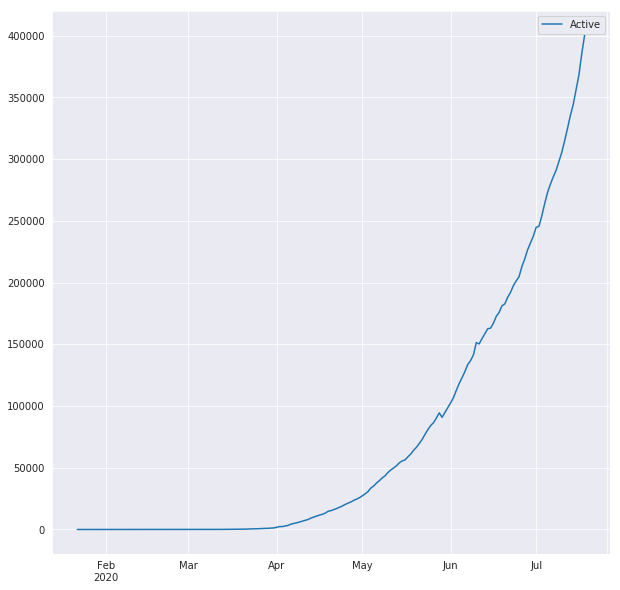

In [148]:
df_india_active.plot()

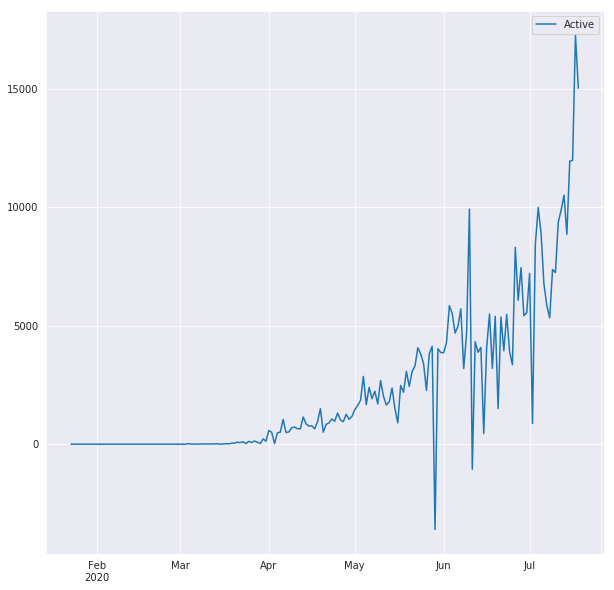

In [149]:
df_india_active.diff(periods=1).dropna().plot()

In [150]:
df_india_active_diff = df_india_active.diff(periods=1).dropna()['Active']

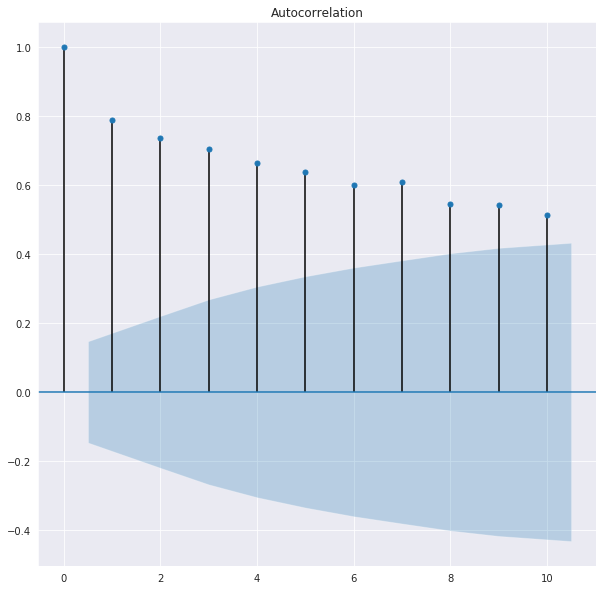

In [151]:
plot_acf(df_india_active_diff, lags=10)
plt.show()

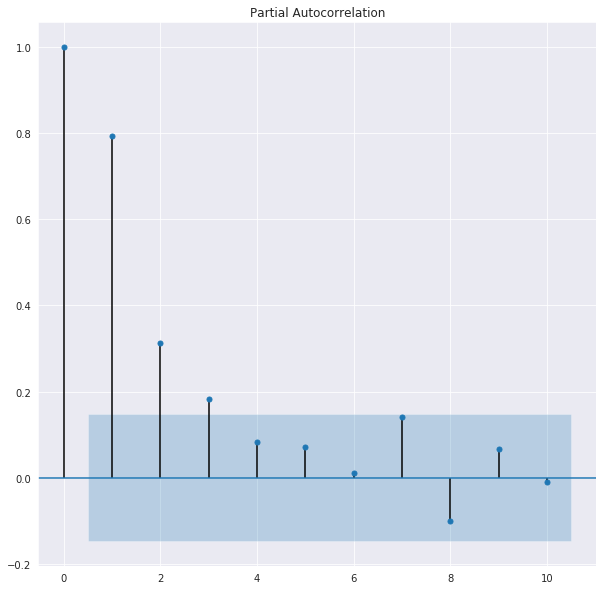

In [152]:
plot_pacf(df_india_active_diff, lags=10)
plt.show()

In [153]:
list_tup = get_list_of_arma_model_parameters(df_india_active_diff, 2)
ar, ma, aic, bic = get_best_ar_ma_value(list_tup)
ARIMA_model = ARIMA(df_india_active, order=(ar, 2, ma)).fit(transparams=False)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params a

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was pr

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was pr

On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own s

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

In [154]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D2.Active   No. Observations:                  177
Model:                 ARIMA(0, 2, 9)   Log Likelihood               -1522.018
Method:                       css-mle   S.D. of innovations           1284.588
Date:                Sun, 19 Jul 2020   AIC                           3066.036
Time:                        16:13:32   BIC                           3100.973
Sample:                    01-24-2020   HQIC                          3080.205
                         - 07-18-2020                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              82.0859     42.174      1.946      0.052      -0.573     164.745
ma.L1.D2.Active    -0.8276      0.074    -11.199      0.000      -0.972      -0.683
ma.L2.D2.Active     0.3015      0.099      3.057      0.002       0.108       0.495
ma.L3.D2.Active     0.1267      0.100      1.265      0.206      -0.070       0.323
ma.L4.D2.Active    -0.1421      0.109     -1.308      0.191      -0.355       0.071
ma.L5.D2.Active    -0.0917      0.112     -0.817      0.414      -0.312       0.128
ma.L6.D2.Active    -0.0733      0.122     -0.598      0.550      -0.313       0.167
ma.L7.D2.Active     0.5057      0.117      4.317      0.000       0.276       0.735
ma.L8.D2.Active    -0.2131      0.111     -1.920      0.055      -0.431       0.004
ma.L9.D2.Active    -0.1627      0.077     -2.115      0.034      -0.313      -0.012
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.1942           -0.0000j            1.1942           -0.0000
MA.2            0.9496           -0.5873j            1.1166           -0.0882
MA.3            0.9496           +0.5873j            1.1166            0.0882
MA.4            0.3201           -0.9474j            1.0000           -0.1981
MA.5            0.3201           +0.9474j            1.0000            0.1981
MA.6           -0.6369           -0.9651j            1.1563           -0.3428
MA.7           -0.6369           +0.9651j            1.1563            0.3428
MA.8           -1.2032           -0.0000j            1.2032           -0.5000
MA.9           -2.5663           -0.0000j            2.5663           -0.5000
-----------------------------------------------------------------------------
"""

In [155]:
ARIMA_model.predict('2020-02-24', '2020-07-15', typ='levels')

2020-02-24       194.103189
2020-02-25       204.501264
2020-02-26       204.794065
2020-02-27       194.767051
2020-02-28       189.281468
2020-02-29       195.000136
2020-03-01       205.196508
2020-03-02       206.341264
2020-03-03       199.474772
2020-03-04       193.329343
2020-03-05       224.678864
2020-03-06       239.892347
2020-03-07       242.181245
2020-03-08       230.624875
2020-03-09       226.665384
2020-03-10       233.180918
2020-03-11       269.066058
2020-03-12       274.184483
2020-03-13       270.228121
2020-03-14       269.822438
2020-03-15       300.509627
2020-03-16       316.539319
2020-03-17       328.822306
2020-03-18       331.660642
2020-03-19       338.787040
                  ...      
2020-06-21    187673.727606
2020-06-22    191758.375172
2020-06-23    196652.441521
2020-06-24    202304.463918
2020-06-25    206190.315370
2020-06-26    210335.718396
2020-06-27    216791.864864
2020-06-28    224467.465785
2020-06-29    234074.608389
2020-06-30    240257

In [156]:
arma_predict2 = ARIMA_model.predict('2020-03-24', '2020-07-15', typ='levels')
ser2 = arma_predict2

### Mean Absolute Error for Forecast Evaluation

In [157]:
actual = df_india_active.loc['2020-01-24':]

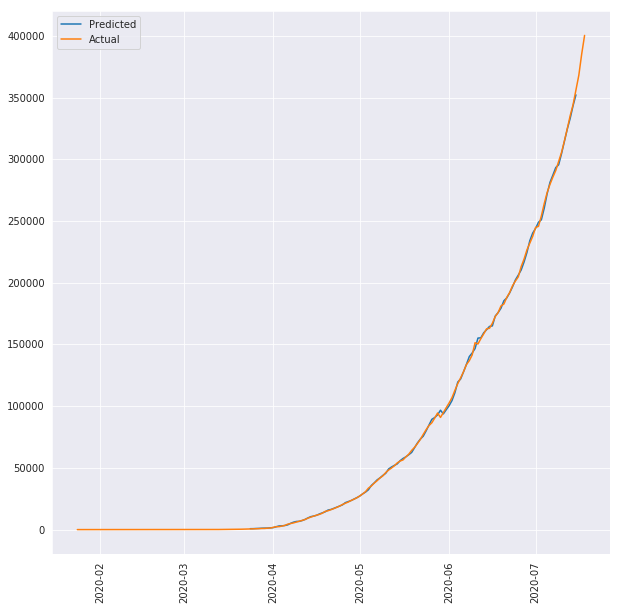

In [158]:
plt.plot(ser2, label='Predicted')
plt.plot(actual, label='Actual')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [159]:
df_new = pd.DataFrame(actual)

In [160]:
df_new['predicted'] = ser2

In [161]:
df_new.tail()

,Active,predicted
2020-07-14,344149,343382.918092
2020-07-15,356089,352181.758767
2020-07-16,368075,NaN
2020-07-17,385333,NaN
2020-07-18,400358,NaN


In [162]:
df_new.loc[:, 'error'] = np.absolute(df_new.predicted - df_new.Active)

In [163]:
df_new.tail()

,Active,predicted,error
2020-07-14,344149,343382.918092,766.081908
2020-07-15,356089,352181.758767,3907.241233
2020-07-16,368075,NaN,NaN
2020-07-17,385333,NaN,NaN
2020-07-18,400358,NaN,NaN


In [164]:
df_new.loc[:, 'error_squared'] = np.square(df_new.predicted - df_new.Active)

In [165]:
df_new = df_new.dropna()

In [166]:
sum(df_new.error_squared) / len(df_new)

2370108.6962036346

In [167]:
np.sqrt(sum(df_new.error_squared) / len(df_new))

1539.5157343150588

In [168]:
root_mean_square_error = np.sqrt(sum(df_new.error_squared) / len(df_new))

In [169]:
root_mean_square_error

1539.5157343150588

### Forecast India's Confirmed Cases

### India Confirmed Cases

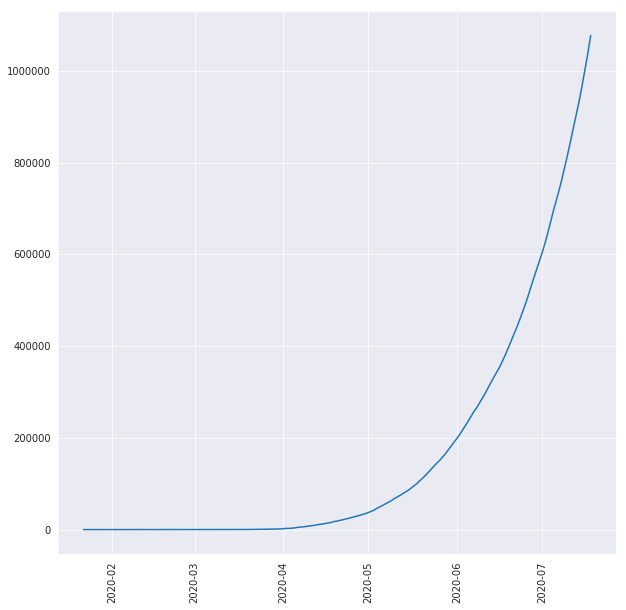

In [170]:
df_trans_confirmed_ind = df_trans[['India']]
plt.plot(df_trans_confirmed_ind)
plt.xticks(rotation=90)
plt.show()

In [171]:
df_ind1 = df_trans_confirmed_ind.diff().fillna(df_trans_confirmed_ind)
df_ind1.tail()

Country/Region,India
2020-07-14,29429.0
2020-07-15,32676.0
2020-07-16,34975.0
2020-07-17,35252.0
2020-07-18,38697.0


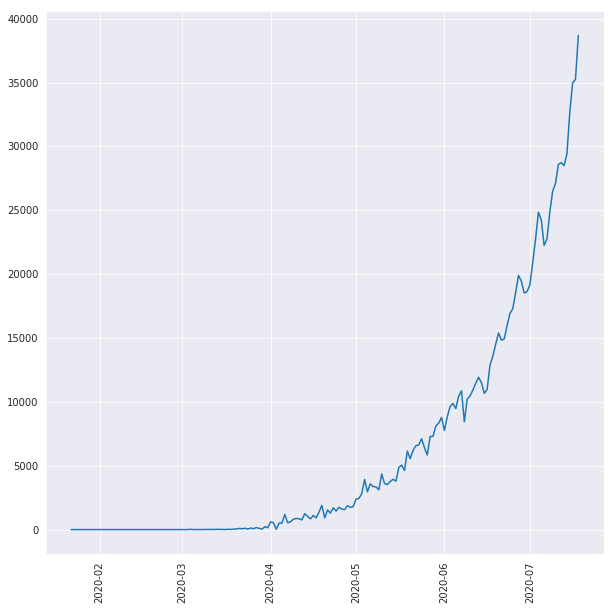

In [172]:
plt.plot(df_ind1)
plt.xticks(rotation=90)
plt.show()

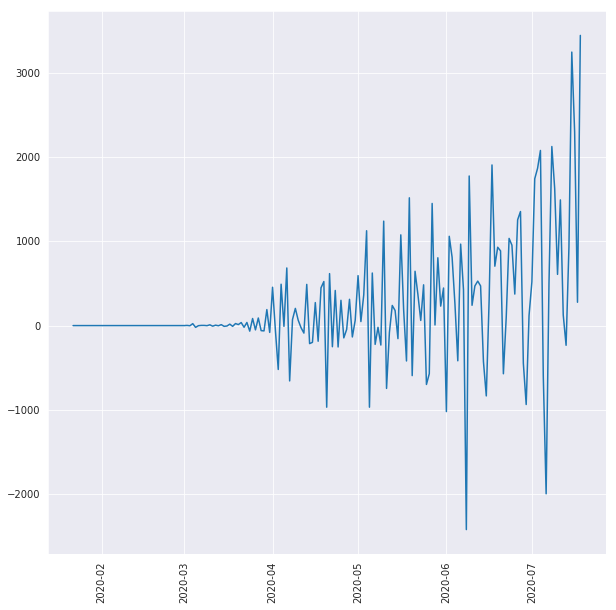

In [173]:
df_ind2 = df_ind1.diff().fillna(df_ind1)
plt.plot(df_ind2)
plt.xticks(rotation=90)
plt.show()

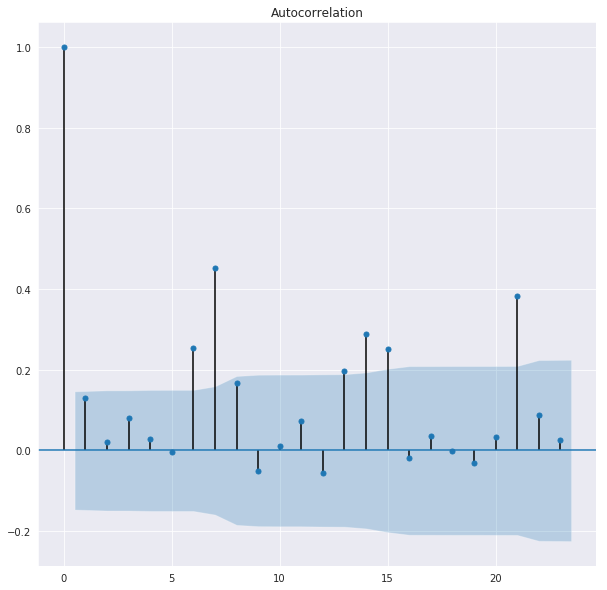

In [174]:
plot_acf(df_ind2)
plt.show()

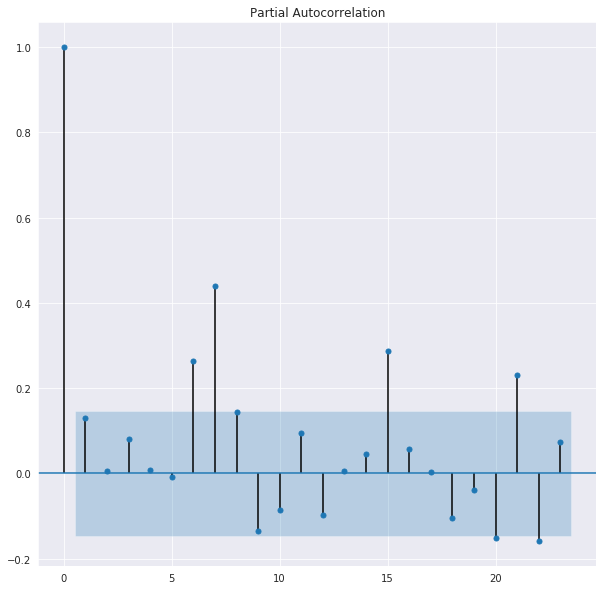

In [175]:
plot_pacf(df_ind2)
plt.show()

In [176]:
list_tup = get_list_of_arma_model_parameters(df_trans_confirmed_ind, 2)
ar, ma, aic, bic = get_best_ar_ma_value(list_tup)
ARIMA_model = ARIMA(df_trans_confirmed_ind, order=(ar, 2, ma)).fit(transparams=False)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

SVD did not converge
SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

On entry to DLASCL parameter number 4 had an illegal value
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SVD did not converge
SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SVD did not converge
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
On entry to DLASCL parameter number 4 had an illegal value
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

SVD did not converge
SVD did not converge
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

On entry to DLASCL parameter number 4 had an illegal value
On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own s

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own s

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own s

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

In [177]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.India   No. Observations:                  177
Model:                 ARIMA(5, 2, 2)   Log Likelihood               -1381.084
Method:                       css-mle   S.D. of innovations                nan
Date:                Sun, 19 Jul 2020   AIC                           2780.168
Time:                        16:14:07   BIC                           2808.754
Sample:                    01-24-2020   HQIC                          2791.761
                         - 07-18-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            559.9361    694.631      0.806      0.420    -801.515    1921.387
ar.L1.D2.India     1.3938      0.085     16.412      0.000       1.227       1.560
ar.L2.D2.India    -0.8332      0.136     -6.119      0.000      -1.100      -0.566
ar.L3.D2.India     0.2677      0.150      1.781      0.075      -0.027       0.562
ar.L4.D2.India    -0.2981      0.135     -2.205      0.027      -0.563      -0.033
ar.L5.D2.India     0.4248      0.083      5.091      0.000       0.261       0.588
ma.L1.D2.India    -1.5127      0.047    -32.477      0.000      -1.604      -1.421
ma.L2.D2.India     0.9119      0.042     21.595      0.000       0.829       0.995
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0293           -0.0000j            1.0293           -0.0000
AR.2            0.6669           -0.8065j            1.0465           -0.1400
AR.3            0.6669           +0.8065j            1.0465            0.1400
AR.4           -0.8307           -1.1825j            1.4451           -0.3475
AR.5           -0.8307           +1.1825j            1.4451            0.3475
MA.1            0.8294           -0.6393j            1.0472           -0.1045
MA.2            0.8294           +0.6393j            1.0472            0.1045
-----------------------------------------------------------------------------
"""

In [178]:
arma_predict = ARIMA_model.predict('2020-06-05', '2020-07-15', typ='levels')

In [179]:
arma_predict

2020-06-05    237605.212660
2020-06-06    246077.780422
2020-06-07    256938.848998
2020-06-08    267988.538756
2020-06-09    274772.438629
2020-06-10    286574.246459
2020-06-11    296786.683075
2020-06-12    309220.318380
2020-06-13    320352.284327
2020-06-14    332832.295139
2020-06-15    344204.033734
2020-06-16    354455.235427
2020-06-17    365732.752722
2020-06-18    380167.149613
2020-06-19    394241.040368
2020-06-20    409474.406496
2020-06-21    425349.914492
2020-06-22    440443.971150
2020-06-23    456336.108177
2020-06-24    473534.143424
2020-06-25    491603.638850
2020-06-26    508880.172548
2020-06-27    527752.595823
2020-06-28    548279.079209
2020-06-29    567630.985028
2020-06-30    585832.568661
2020-07-01    604914.553581
2020-07-02    625001.179065
2020-07-03    647519.938823
2020-07-04    671260.357513
2020-07-05    697587.875339
2020-07-06    721317.154405
2020-07-07    742739.639833
2020-07-08    766552.007629
2020-07-09    793853.501332
2020-07-10    822059

In [180]:
undiff1 = df_ind2.cumsum().fillna(df_ind2)
undiff2 = df_ind1.cumsum().fillna(df_ind1)

### Mean Absolute Error for Forecast Evaluation

In [181]:
arma_predict2 = ARIMA_model.predict('2020-01-24', '2020-08-15', typ='levels')
ser2 = arma_predict2

In [182]:
ser2.diff()

2020-01-24             NaN
2020-01-25     -233.724746
2020-01-26      -62.822416
2020-01-27      -69.182301
2020-01-28       -3.581495
2020-01-29      -57.730344
2020-01-30      -48.067406
2020-01-31      -23.604487
2020-02-01      -11.268603
2020-02-02       -0.182848
2020-02-03        7.436644
2020-02-04       11.083654
2020-02-05        9.402424
2020-02-06        6.205335
2020-02-07       -0.699175
2020-02-08       -6.548958
2020-02-09       -8.921063
2020-02-10       -6.769743
2020-02-11       -2.875126
2020-02-12        1.027513
2020-02-13        3.976089
2020-02-14        5.313254
2020-02-15        4.556713
2020-02-16        1.837199
2020-02-17       -1.612433
                  ...     
2020-07-22    44405.368426
2020-07-23    46362.891965
2020-07-24    48485.769540
2020-07-25    50007.654920
2020-07-26    51317.906007
2020-07-27    52599.046717
2020-07-28    53924.330622
2020-07-29    55528.123023
2020-07-30    57283.342020
2020-07-31    58948.163638
2020-08-01    60409.847860
2

### Note:

- The model predicted number of deaths on 13th June as 648.
- Actual number of deaths on 13th June: 654

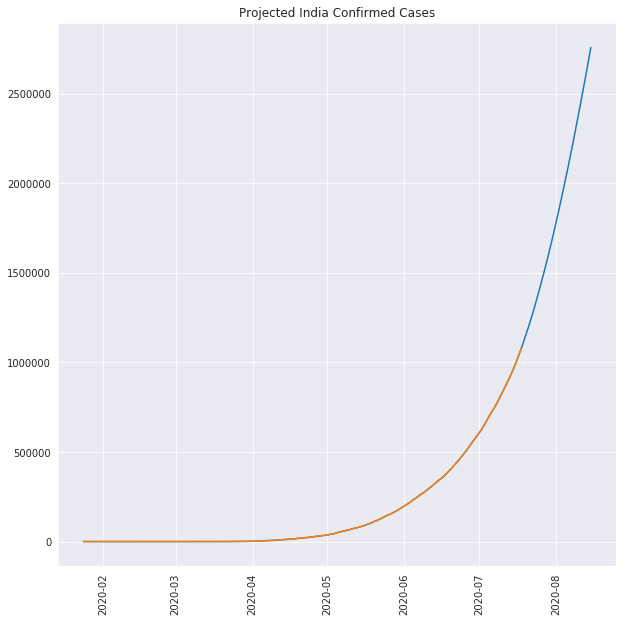

In [183]:
actual = df_trans_confirmed_ind.loc['2020-01-24':, :]
plt.plot(ser2)
plt.plot(actual)
plt.xticks(rotation=90)
plt.title('Projected India Confirmed Cases')
plt.show()

### Converting DataFrame to actual time series data, where each day has number of deaths i.e deaths value is not cumulated.

In [184]:
df_trans_deaths_us = df_trans_deaths[['US']]

In [185]:
df_trans_deaths_us = df_trans_deaths_us.diff(axis=0).fillna(df_trans_deaths_us)

In [186]:
df_trans_deaths_us.tail()

Country/Region,US
2020-07-14,900.0
2020-07-15,949.0
2020-07-16,943.0
2020-07-17,908.0
2020-07-18,853.0


In [187]:
df_trans_deaths_us.index

DatetimeIndex(['2020-01-22', '2020-01-23',
               '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27',
               '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2020-07-09', '2020-07-10',
               '2020-07-11', '2020-07-12',
               '2020-07-13', '2020-07-14',
               '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-18'],
              dtype='datetime64[ns]', length=179, freq=None)

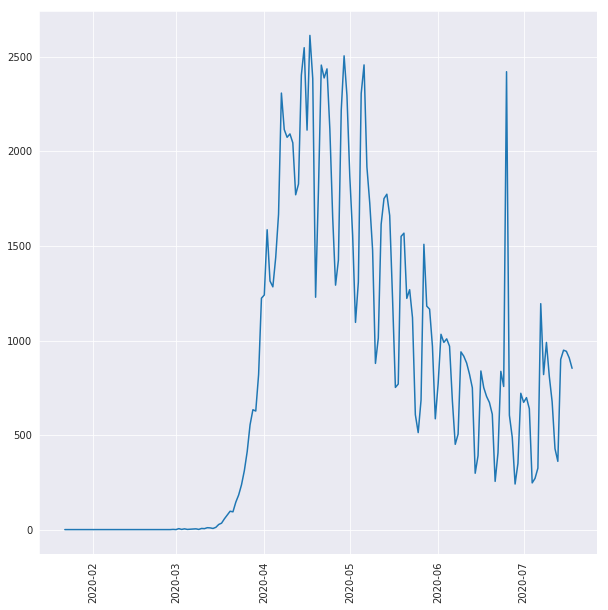

In [188]:
plt.plot(df_trans_deaths_us)
plt.xticks(rotation=90)
plt.show()

In [189]:
df_us1 = df_trans_deaths_us.diff().fillna(df_trans_deaths_us)
df_us1.tail()

Country/Region,US
2020-07-14,539.0
2020-07-15,49.0
2020-07-16,-6.0
2020-07-17,-35.0
2020-07-18,-55.0


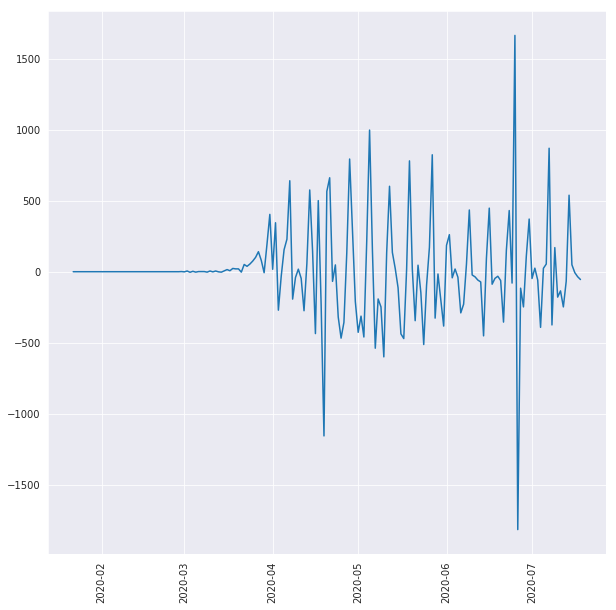

In [190]:
plt.plot(df_us1)
plt.xticks(rotation=90)
plt.show()

In [191]:
df_us1 = df_trans_deaths_us.diff().fillna(df_trans_deaths_us)
df_us1.tail()

Country/Region,US
2020-07-14,539.0
2020-07-15,49.0
2020-07-16,-6.0
2020-07-17,-35.0
2020-07-18,-55.0


In [192]:
df_us2 = df_us1.diff().fillna(df_us1)
df_us2.tail()

Country/Region,US
2020-07-14,606.0
2020-07-15,-490.0
2020-07-16,-55.0
2020-07-17,-29.0
2020-07-18,-20.0


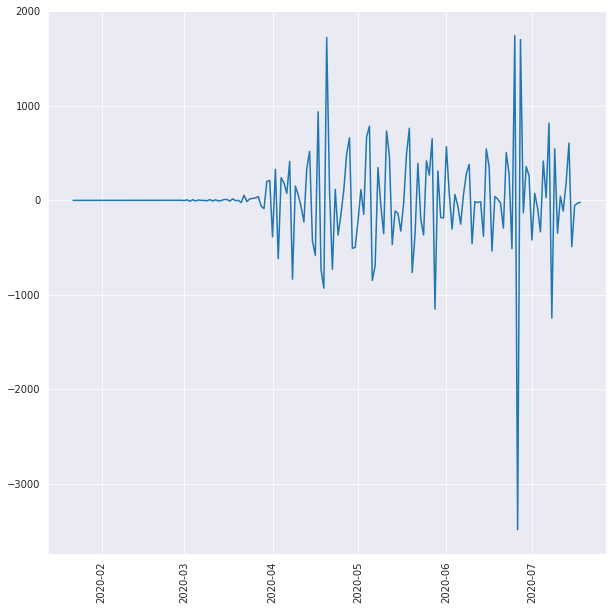

In [193]:
df_us2 = df_us1.diff().fillna(df_us1)
plt.plot(df_us2)
plt.xticks(rotation=90)
plt.show()

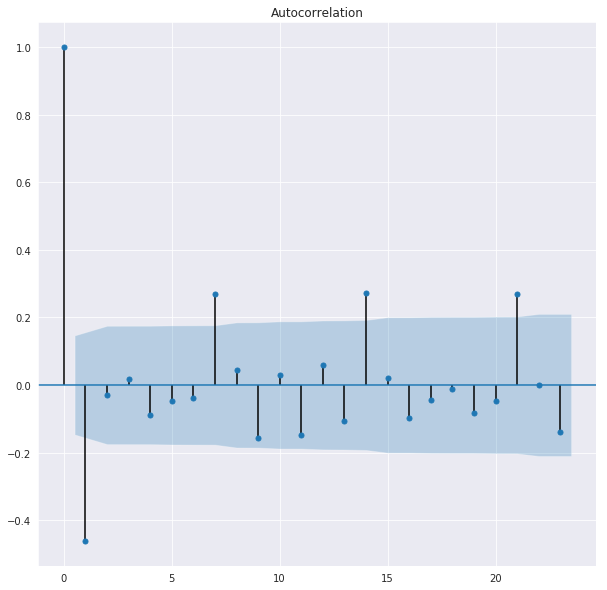

In [194]:
plot_acf(df_us2)
plt.show()

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


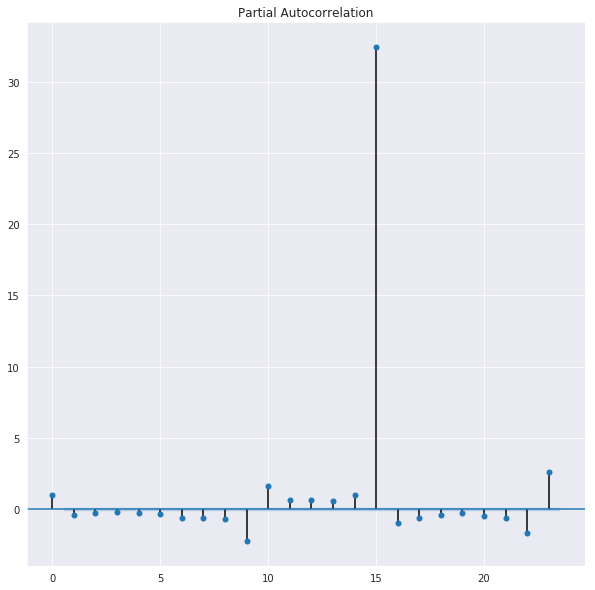

In [195]:
plot_pacf(df_us2)
plt.show()

In [196]:
ARIMA_model = ARIMA(df_trans_deaths_us, order=(9, 1, 6)).fit(transparams=False)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [ ]:
ARIMA_model.summary()

In [ ]:
arma_predict = ARIMA_model.predict('2020-06-05', '2020-06-25', typ='levels')

In [ ]:
arma_predict

### Mean Absolute Error for Forecast Evaluation

In [ ]:
arma_predict2 = ARIMA_model.predict('2020-01-23', '2020-06-25', typ='levels')
ser2 = arma_predict2

In [ ]:
actual = df_trans_deaths_us.loc['2020-01-24':, :]

In [ ]:
plt.plot(ser2, label='Predicted')
plt.plot(actual, label='Actual')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
df_new = pd.DataFrame(actual)

In [ ]:
df_new['predicted'] = ser2

In [ ]:
df_new = df_new.rename(columns={"US":"actual"})

In [ ]:
df_new.loc[:, 'error'] = np.absolute(df_new.predicted - df_new.actual)

In [ ]:
df_new.tail()

In [ ]:
df_new.loc[:, 'error_squared'] = np.square(df_new.predicted - df_new.actual)

In [ ]:
sum(df_new.error_squared) / len(df_new)

In [ ]:
np.sqrt(sum(df_new.error_squared) / len(df_new))

In [ ]:
root_mean_square_error = np.sqrt(sum(df_new.error_squared) / len(df_new))

In [ ]:
test_results = adfuller(df_us2.US)

In [ ]:
test_results[1]

### India

### Converting DataFrame to actual time series data, where each day has number of deaths i.e deaths value is not cumulated.

In [ ]:
df_trans_deaths_ind = df_trans_deaths[['India']]

In [ ]:
df_trans_deaths_ind = df_trans_deaths_ind.diff(axis=0).fillna(df_trans_deaths_ind)

In [ ]:
plt.plot(df_trans_deaths_ind)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_ind1 = df_trans_deaths_ind.diff().fillna(df_trans_deaths_ind)
df_ind1.tail()

In [ ]:
plt.plot(df_ind1)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_ind2 = df_ind1.diff().fillna(df_ind1)
df_ind2.tail()

In [ ]:
df_ind2 = df_ind1.diff().fillna(df_ind1)
plt.plot(df_ind2)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plot_acf(df_ind2)
plt.show()

In [ ]:
plot_pacf(df_ind2)
plt.show()

In [ ]:
list_tup = get_list_of_arma_model_parameters(df_trans_deaths_ind, 2)
ar, ma, aic, bic = get_best_ar_ma_value(list_tup)
ARIMA_model = ARIMA(df_trans_deaths_ind, order=(ar, 2, ma)).fit(transparams=False)

In [ ]:
ARIMA_model.summary()

In [ ]:
arma_predict = ARIMA_model.predict('2020-06-05', '2020-07-15', typ='levels')

In [ ]:
arma_predict

### Mean Absolute Error for Forecast Evaluation

In [ ]:
arma_predict2 = ARIMA_model.('2020-01-24', '2020-06-28', typ='levels')
ser2 = arma_predict2

In [ ]:
actual = df_trans_deaths_ind.loc['2020-01-24':, :]

In [ ]:
plt.plot(ser2, label='Predicted')
plt.plot(actual, label='Actual')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
df_new = pd.DataFrame(actual)

In [ ]:
df_new['predicted'] = ser2

In [ ]:
df_new = df_new.rename(columns={"India":"actual"})

In [ ]:
df_new.loc[:, 'error'] = np.absolute(df_new.predicted - df_new.actual)

In [ ]:
df_new.tail()

In [ ]:
df_new.loc[:, 'error_squared'] = np.square(df_new.predicted - df_new.actual)

In [ ]:
sum(df_new.error_squared) / len(df_new)

In [ ]:
np.sqrt(sum(df_new.error_squared) / len(df_new))

In [ ]:
root_mean_square_error = np.sqrt(sum(df_new.error_squared) / len(df_new))

In [ ]:
root_mean_square_error